# The Fed Funds Rate's Influence on Stock Returns

<p>The objective of this research is to determine what influence the Federal Reserve's actions on interest rate manipulation have on the stock market. We will attempt to answer four questions:</p>
<ol>
    <li>What is the overall Federal Funds Rate (FFR)'s relationship with stock returns, on a daily, weekly, and monthly basis?</li>
    <li>What is the FFR trajectory's relationship with stock returns, on a daily, weekly, and monthly basis?</li>
    <li>What is the overall FFR's relationship with large, outsized moves in stocks?</li>
    <li>What is the FFR trajectory's relationship with large, outsized moves in stocks?</li>
</ol>
<p><strong>Datasets used</strong>: S&P 500 close data per <a href="https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC">Yahoo Finance</a>, running from 1976 through 2022, and <a href="https://fred.stlouisfed.org/series/DFF#0">the Federal Reserve Bank of St. Louis</a> for the same period. While we could look at a longer timeframe, the Fed's actions were likely less influential when the dollar was exchangeable for gold bullion, a paradigm that came to an end in 1971.</p>

<p>Chapters with links:</p>
<ul>
    <li><a href='#Data-Imports-and-EDA'>Data Imports and EDA</a></li>
    <li><a href='#Data-Cleaning'>Data Cleaning</a></li>
    <li><a href='#Data-Manipulation'>Data Manipulation</a></li>
    <li><a href='#Analysis-and-Findings'>Analysis and Findings</a></li>
</ul>
<p><strong>Note:</strong> From a trading perspective, the purpose of this research should be clear. From a data analytic perspective, the purpose of this research is also to show how much can be done with a two-column dataset. It is proof that one does not need 80 columns to come up with valuable insights.</p>

## Data Imports and EDA

In [1099]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime

In [1100]:
# Read in SPX file
spx = pd.read_csv('../data/SPX Full 7622.csv')
spx.head()

,Date,Close
0,1/2/1976,90.90
1,1/5/1976,92.60
2,1/6/1976,93.50
3,1/7/1976,93.90
4,1/8/1976,94.60


In [1101]:
spx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11853 entries, 0 to 11852
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    11853 non-null  object
 1   Close   11853 non-null  object
dtypes: object(2)
memory usage: 185.3+ KB


In [1102]:
# Read in FFR file
ffr = pd.read_csv('data/DFF.csv')
ffr.head()

,DATE,DFF
0,1976-01-01,5.37
1,1976-01-02,5.28
2,1976-01-03,5.28
3,1976-01-04,5.28
4,1976-01-05,5.29


In [1103]:
ffr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17167 entries, 0 to 17166
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    17167 non-null  object 
 1   DFF     17167 non-null  float64
dtypes: float64(1), object(1)
memory usage: 268.4+ KB


## Data Cleaning

The data looks complete, clean, and there are no missing values. There are a few data cleaning issues to resolve:

<ul>
    <li>SPX has an unusual date format that should be changed to FFR date format.</li>
    <li>Dates need to be formatted as such.</li>
    <li>SPX Close is formatted as text, rather than numeric.</li>
</ul>

In [1104]:
# Format FFR date as such
ffr.DATE = pd.to_datetime(ffr.DATE)
# Set date as the index
ffr = ffr.set_index('DATE')

In [1106]:
# Double check
ffr.head()

,DFF
DATE,
1976-01-01,5.37
1976-01-02,5.28
1976-01-03,5.28
1976-01-04,5.28
1976-01-05,5.29


In [1108]:
# Fix SPX date
spx.Date = pd.to_datetime(spx.Date)
spx.rename(columns = {'Date': 'DATE'}, inplace = True)

AttributeError: 'DataFrame' object has no attribute 'Date'

In [1109]:
# Double check
spx.head()

,DATE,Close
0,1976-01-02,90.90
1,1976-01-05,92.60
2,1976-01-06,93.50
3,1976-01-07,93.90
4,1976-01-08,94.60


In [1110]:
# SPX: Set index
spx.set_index('DATE', inplace = True)

In [1111]:
# Remove the commas in Close and convert to float
spx.Close = spx.Close.str.replace(',','').astype('float')

In [1112]:
# Take a look
spx.head()

,Close
DATE,
1976-01-02,90.9
1976-01-05,92.6
1976-01-06,93.5
1976-01-07,93.9
1976-01-08,94.6


## Data Manipulation

Now that the data is cleaned, let's do the following:

<ul>
    <li>Create a single joined dataset that lists every day, the close, and the most recent FFR</li>
    <li>Add SPX change values</li>
    <li>Create resampled datasets for weekly and monthly change values</li>
    <li>Add a column defining the FFR trajectory</li>
    <li>Add the change percentiles to define outliers</li>
    <li>Determine thresholds for the FFR</li>
</ul>

### Create a single joined dataset that lists every day, the close, and the FFR

In [1113]:
df = spx.join(ffr, how = 'left')

In [1114]:
df.head()

,Close,DFF
DATE,,
1976-01-02,90.9,5.28
1976-01-05,92.6,5.29
1976-01-06,93.5,5.05
1976-01-07,93.9,4.26
1976-01-08,94.6,4.84


In [1115]:
# Ensure there are no blanks
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11853 entries, 1976-01-02 to 2022-12-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   11853 non-null  float64
 1   DFF     11853 non-null  float64
dtypes: float64(2)
memory usage: 535.8 KB


Joining is done. Nice!

In [1116]:
# Column names aren't useful
df.rename(columns = {'Close': 'close', 'DFF': 'FFR'}, inplace = True)

In [1117]:
df.head()

,close,FFR
DATE,,
1976-01-02,90.9,5.28
1976-01-05,92.6,5.29
1976-01-06,93.5,5.05
1976-01-07,93.9,4.26
1976-01-08,94.6,4.84


### Add SPX change values

In [1118]:
# Add new columns with close and FFR lagged by one day
df = df.join(df.shift(periods = 1), rsuffix = '_1d')
# Drop FFR change
df = df.drop('FFR_1d', axis = 1)
df.head()

,close,FFR,close_1d
DATE,,,
1976-01-02,90.9,5.28,NaN
1976-01-05,92.6,5.29,90.9
1976-01-06,93.5,5.05,92.6
1976-01-07,93.9,4.26,93.5
1976-01-08,94.6,4.84,93.9


In [1119]:
# Calculate day change as a percentage
df['day_chg'] = round((df['close'] / df['close_1d'] - 1) * 100, 2)
df.head()

,close,FFR,close_1d,day_chg
DATE,,,,
1976-01-02,90.9,5.28,NaN,NaN
1976-01-05,92.6,5.29,90.9,1.87
1976-01-06,93.5,5.05,92.6,0.97
1976-01-07,93.9,4.26,93.5,0.43
1976-01-08,94.6,4.84,93.9,0.75


In [1120]:
# Run summary stats on day change
df.day_chg.describe()

count    11852.000000
mean         0.037721
std          1.105058
min        -20.480000
25%         -0.450000
50%          0.060000
75%          0.560000
max         11.580000
Name: day_chg, dtype: float64

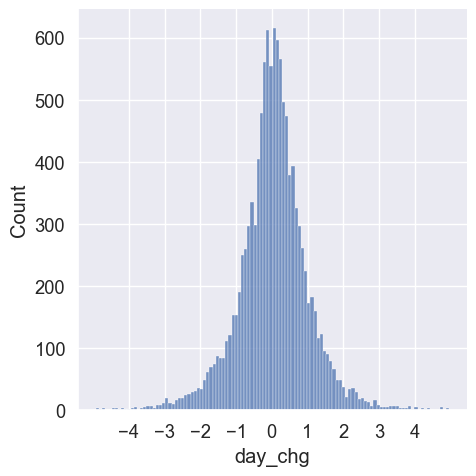

In [1122]:
# Plot day change returns with 5+% outliers taken out
g = sns.displot(data = df[(df.day_chg > -5) & (df.day_chg < 5)], x = 'day_chg')
g.set(xticks = np.arange(-4, 5, 1))
plt.show()

In [1123]:
# It is interesting that there is a negative skew
# Let's look at the numbers for this
print("Between -2.5% and -3.5%:",df[(df.day_chg < -2.5) & (df.day_chg > -3.5)].shape[0], "rows")
print("Between 2.5% and 3.5%:", df[(df.day_chg > 2.5) & (df.day_chg < 3.5)].shape[0], "rows")
# There are more large losses than large gains, although it's not clear whether this is statsig

Between -2.5% and -3.5%: 125 rows
Between 2.5% and 3.5%: 109 rows


In [1124]:
# Validate that percentages are correct
df['1987-10-10':'1987-10-25']

,close,FFR,close_1d,day_chg
DATE,,,,
1987-10-12,309.4,7.58,311.1,-0.55
1987-10-13,314.5,7.65,309.4,1.65
1987-10-14,305.2,7.59,314.5,-2.96
1987-10-15,298.1,7.76,305.2,-2.33
1987-10-16,282.7,7.55,298.1,-5.17
1987-10-19,224.8,7.61,282.7,-20.48
1987-10-20,236.8,7.07,224.8,5.34
1987-10-21,258.4,6.47,236.8,9.12
1987-10-22,248.3,7.14,258.4,-3.91


The legendary Black Monday 1987 indeed shows the 20.48% drop it is known for.

In [1125]:
# Add new column to track average gain
df['gain'] = df.day_chg.apply(lambda chg: 0 if chg < 0 else chg)

In [1126]:
df.head()

,close,FFR,close_1d,day_chg,gain
DATE,,,,,
1976-01-02,90.9,5.28,NaN,NaN,NaN
1976-01-05,92.6,5.29,90.9,1.87,1.87
1976-01-06,93.5,5.05,92.6,0.97,0.97
1976-01-07,93.9,4.26,93.5,0.43,0.43
1976-01-08,94.6,4.84,93.9,0.75,0.75


### Create resampled datasets for weekly and monthly change values

In [1127]:
# Add weekday
df['weekday'] = df.index.weekday + 1
df.head()

,close,FFR,close_1d,day_chg,gain,weekday
DATE,,,,,,
1976-01-02,90.9,5.28,NaN,NaN,NaN,5
1976-01-05,92.6,5.29,90.9,1.87,1.87,1
1976-01-06,93.5,5.05,92.6,0.97,0.97,2
1976-01-07,93.9,4.26,93.5,0.43,0.43,3
1976-01-08,94.6,4.84,93.9,0.75,0.75,4


In [1130]:
# Create a new DataFrame for weekly change
df_w = df.resample('W').last()[['close', 'FFR', 'weekday']]
df_w.tail()
# This works well since each row is a Sunday
# Since the S&P has never been open on a Sunday, it is guaranteed to reflect the weekly 
# change without interference from holidays

,close,FFR,weekday
DATE,,,
2022-12-04,4071.70,3.83,5
2022-12-11,3934.38,3.83,5
2022-12-18,3852.36,4.33,5
2022-12-25,3844.82,4.33,5
2023-01-01,3839.50,4.33,5


In [1131]:
# Add new columns with close and FFR lagged by one week
df_w = df_w.join(df_w.shift(periods = 1), rsuffix = '_1w')
df_w.head()

,close,FFR,weekday,close_1w,FFR_1w,weekday_1w
DATE,,,,,,
1976-01-04,90.9,5.28,5,NaN,NaN,NaN
1976-01-11,94.9,4.73,5,90.9,5.28,5.0
1976-01-18,97.0,4.82,5,94.9,4.73,5.0
1976-01-25,99.2,4.72,5,97.0,4.82,5.0
1976-02-01,100.9,4.84,5,99.2,4.72,5.0


In [1132]:
# Drop unnecessary columns
df_w = df_w.drop(['FFR_1w', 'weekday_1w'], axis = 1)
df_w.head()

,close,FFR,weekday,close_1w
DATE,,,,
1976-01-04,90.9,5.28,5,NaN
1976-01-11,94.9,4.73,5,90.9
1976-01-18,97.0,4.82,5,94.9
1976-01-25,99.2,4.72,5,97.0
1976-02-01,100.9,4.84,5,99.2


In [1133]:
# Calculate week over week change as a percentage
df_w['wk_chg'] = round((df_w['close'] / df_w['close_1w'] - 1) * 100, 2)
df_w.head()

,close,FFR,weekday,close_1w,wk_chg
DATE,,,,,
1976-01-04,90.9,5.28,5,NaN,NaN
1976-01-11,94.9,4.73,5,90.9,4.40
1976-01-18,97.0,4.82,5,94.9,2.21
1976-01-25,99.2,4.72,5,97.0,2.27
1976-02-01,100.9,4.84,5,99.2,1.71


In [1134]:
# Add new column to track average gain
df_w['gain'] = df_w.wk_chg.apply(lambda chg: 0 if chg < 0 else chg)

In [1135]:
# Let's do data validation on a non-standard week
# The market was closed April 15, 2022
df['2022-04-08':'2022-04-08']
# On April 8, it closed at 4488.28

,close,FFR,close_1d,day_chg,gain,weekday
DATE,,,,,,
2022-04-08,4488.28,0.33,4500.21,-0.27,0.0,5


In [1136]:
df['2022-04-14':'2022-04-14']
# On April 14, it closed at 4392.59

,close,FFR,close_1d,day_chg,gain,weekday
DATE,,,,,,
2022-04-14,4392.59,0.33,4446.59,-1.21,0.0,4


In [1137]:
print("Change: ", (4392.59 / 4488.28) - 1)

Change:  -0.021319971124796


In [1138]:
df_w['2022-04-17':'2022-04-17']

,close,FFR,weekday,close_1w,wk_chg,gain
DATE,,,,,,
2022-04-17,4392.59,0.33,4,4488.28,-2.13,0.0


It's a match! Now we have weekly values, nice.

In [1139]:
# Create a new df for monthly change
df_m = df.resample('M').last()[['close', 'FFR']]
df_m.head()

,close,FFR
DATE,,
1976-01-31,100.9,4.84
1976-02-29,99.7,4.89
1976-03-31,102.8,5.07
1976-04-30,101.6,5.10
1976-05-31,100.2,5.67


In [1140]:
# Add new columns with close and FFR lagged by one month, dropping the lagged FFR value
df_m = df_m.join(df_m.shift(periods = 1), rsuffix = '_1m')[['close', 'FFR', 'close_1m']]
df_m.head()

,close,FFR,close_1m
DATE,,,
1976-01-31,100.9,4.84,NaN
1976-02-29,99.7,4.89,100.9
1976-03-31,102.8,5.07,99.7
1976-04-30,101.6,5.10,102.8
1976-05-31,100.2,5.67,101.6


In [1141]:
# Calculate month over month change as a percentage
df_m['m_chg'] = round((df_m['close'] / df_m['close_1m'] - 1) * 100, 2)
df_m.head()

,close,FFR,close_1m,m_chg
DATE,,,,
1976-01-31,100.9,4.84,NaN,NaN
1976-02-29,99.7,4.89,100.9,-1.19
1976-03-31,102.8,5.07,99.7,3.11
1976-04-30,101.6,5.10,102.8,-1.17
1976-05-31,100.2,5.67,101.6,-1.38


In [1142]:
# Add new column to track average gain
df_m['gain'] = df_m.m_chg.apply(lambda chg: 0 if chg < 0 else chg)

In [1143]:
# Let's do data validation on the last month in the data
# On December 30, 2022, the S&P closed at 3839.5
df['2022-12-30':'2022-12-30']

,close,FFR,close_1d,day_chg,gain,weekday
DATE,,,,,,
2022-12-30,3839.5,4.33,3849.28,-0.25,0.0,5


In [1144]:
df['2022-11-30':'2022-11-30']
# On November 30, it closed at 4080.11

,close,FFR,close_1d,day_chg,gain,weekday
DATE,,,,,,
2022-11-30,4080.11,3.83,3957.63,3.09,3.09,3


In [1145]:
print("Change: ", (3839.5 / 4080.11) - 1)

Change:  -0.058971449299161094


In [1146]:
df_m.tail(1)

,close,FFR,close_1m,m_chg,gain
DATE,,,,,
2022-12-31,3839.5,4.33,4080.11,-5.9,0.0


It's a match! Now we have monthly values, nice.

### Add a column defining the FFR trajectory

In [1147]:
# Let's take a quick look at FFR
df.FFR.describe()

count    11853.000000
mean         4.665367
std          4.045647
min          0.040000
25%          1.030000
50%          4.710000
75%          6.750000
max         22.360000
Name: FFR, dtype: float64

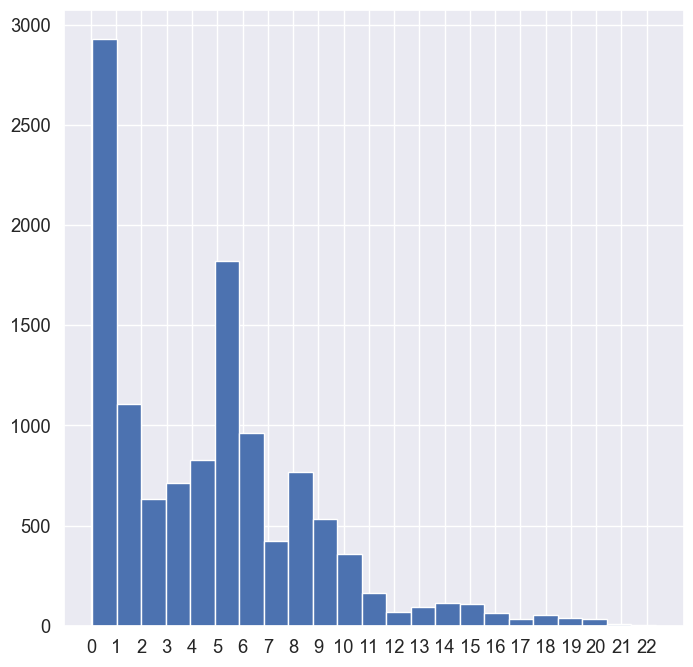

In [1148]:
# Plot FFR
plt.hist(df.FFR, bins = 23)
plt.xticks(ticks = range(0, 23))
plt.show()
# We clearly have peaks near 0-1% and 5-6%, with some very rare 10+% rates

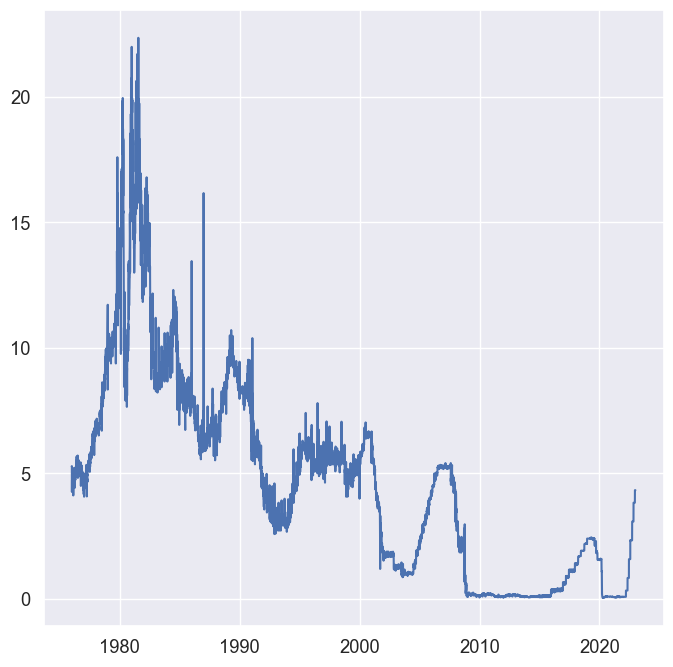

In [1149]:
# Plot FFR against time
plt.plot(df.index, df.FFR)
plt.show()
# As the data shows, FFR's highest points were mostly reached in the 1980s
# Since the mid-1990s, the rate has rarely been over 5%

<strong>Defining the FFR trajectory</strong>

We now need to consider how we want hiking and cutting cycles to be defined. This is a surprisingly hard problem. Especially before the Great Financial Crisis (GFC), there is a <em>considerable</em> amount of fluctuation in the FFR. As a result, defining a hiking cycle as a few days in which the rate has moved would introduce a lot of noise into our findings. We need to clarify what is a <em>cycle</em>, distinct from what is just regular fluctuation.

We need to define three parameters:
<ul>
    <li>The duration of the change in the cost of money that will define a cycle</li>
    <li>The size of the change in the cost of money that will define a cycle</li>
    <li>When the cycle will be considered to have begun and ended</li>
</ul>

The Fed normally meets <a href="https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm">eight times a year</a>, so a duration of less than 1.5 months is likely frivolous. Six months is likely too long, given how quickly things can change in the global economy. Let's settle on three months for the duration question.

For the size question, let's settle on 25 basis points as a meaningful change, per the Fed's own general definition.

More advanced metrics can be explored later, but for now, if the 3-month change is at least 25 bps, and the rate is not down over the previous month, we will consider it a hiking cycle. If the 3-month change is negative 25 bps plus, and the rate is not up over the previous month, we will consider it a cutting cycle. Otherwise, the situation can be considered neutral.

In [1152]:
# Make a new DataFrame to calculate this long term trajectory
df_ffrt = df.copy()
# Make diff periods for 20 and 60 trading days (~1 month and 3 months)
df_ffrt['FFR_20d'] = df_ffrt['FFR'].diff(periods = 20)
df_ffrt['FFR_60d'] = df_ffrt['FFR'].diff(periods = 60)
df_ffrt.iloc[60:65,:]

,close,FFR,close_1d,day_chg,gain,weekday,FFR_20d,FFR_60d
DATE,,,,,,,,
1976-03-29,102.4,4.81,102.8,-0.39,0.00,1,-0.40,-0.47
1976-03-30,102.0,4.88,102.4,-0.39,0.00,2,-0.13,-0.41
1976-03-31,102.8,5.07,102.0,0.78,0.78,3,0.12,0.02
1976-04-01,102.2,4.83,102.8,-0.58,0.00,4,-0.12,0.57
1976-04-02,102.3,4.79,102.2,0.10,0.10,5,-0.18,-0.05


In [1153]:
# Start defining the trajectory using the parameters in the note above
df_ffrt['cycle'] = 'Neutral'
df_ffrt.loc[(df_ffrt.FFR_20d >= 0) & (df_ffrt.FFR_60d >= 0.25), 'cycle'] = 'Hiking'
df_ffrt.loc[(df_ffrt.FFR_20d <= 0) & (df_ffrt.FFR_60d <= -0.25), 'cycle'] = 'Cutting'
df_ffrt.tail(7)

,close,FFR,close_1d,day_chg,gain,weekday,FFR_20d,FFR_60d,cycle
DATE,,,,,,,,,
2022-12-21,3878.44,4.33,3821.62,1.49,1.49,3,0.5,1.25,Hiking
2022-12-22,3822.39,4.33,3878.44,-1.45,0.00,4,0.5,1.25,Hiking
2022-12-23,3844.82,4.33,3822.39,0.59,0.59,5,0.5,1.25,Hiking
2022-12-27,3829.25,4.33,3844.82,-0.40,0.00,2,0.5,1.25,Hiking
2022-12-28,3783.22,4.33,3829.25,-1.20,0.00,3,0.5,1.25,Hiking
2022-12-29,3849.28,4.33,3783.22,1.75,1.75,4,0.5,1.25,Hiking
2022-12-30,3839.50,4.33,3849.28,-0.25,0.00,5,0.5,1.25,Hiking


In [1154]:
# There are about as many values in each category as would reasonably be expected
df_ffrt.cycle.value_counts(normalize = True)

Neutral    0.581456
Hiking     0.235974
Cutting    0.182570
Name: cycle, dtype: float64

### Add the change percentiles to define outliers

Now we need to define the "large, outsized moves in stocks" mentioned in questions 3 and 4. How do we define a large move in the S&P 500? Simply choosing a percentile cutoff seems sufficient for now, although a cutoff that fluctuates based on historical volatility would be advisable for future research. Given our roughly 12,000 data points, a 90th percentile cutoff seems suitable to have a large sample size. A higher cutoff risks excluding almost all data for certain years. Let's find the 90th percentile.

In [1155]:
# Find the daily 90th percentile
d_chg_cutoff = np.percentile(df.day_chg.dropna(), 90).round(2)
d_chg_cutoff

1.17

In [1156]:
# Find how many values are over the cutoff
years_d_chg = df.day_chg >= d_chg_cutoff
years_d_chg = pd.DataFrame(years_d_chg)
# Break out and sum these values by year
years_d_chg['year'] = years_d_chg.index.year
years_d_chg.set_index('year', inplace = True)
years_d_chg = years_d_chg.groupby(['year']).sum()
years_d_chg.head()

,day_chg
year,
1976,20
1977,5
1978,14
1979,12
1980,39


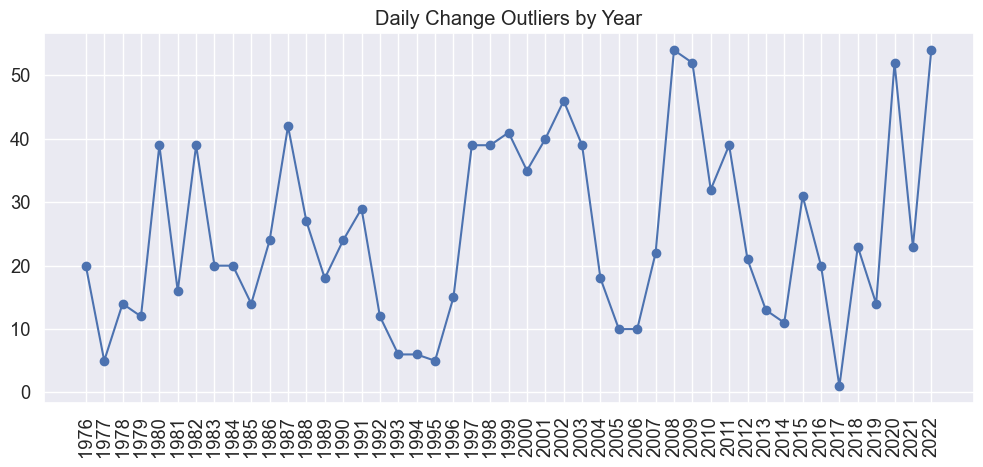

In [1157]:
# Plot the positive outliers by year
f = plt.figure()
# Extra width to fit all the information
f.set_figwidth(12)
f.set_figheight(4.8)
plt.plot(years_d_chg, marker = 'o')
# Show all years
plt.xticks(ticks = range(1976, 2023), rotation = 90)
plt.title('Daily Change Outliers by Year')
plt.show()
# With the exception of the bizarre outlier 2017, most years have enough values to draw sensible conclusions

Now let's repeat the process for weekly change. Since sample size will be much lower for weeks, let's select a lower cutoff, the 80th percentile.

In [1158]:
# Find the weekly 80th percentile
w_chg_cutoff = np.percentile(df_w.wk_chg.dropna(), 80).round(2)
w_chg_cutoff

1.71

In [1159]:
# Find how many values are over the cutoff
years_w_chg = df_w.wk_chg >= w_chg_cutoff
years_w_chg = pd.DataFrame(years_w_chg)
# Break out and sum these values by year
years_w_chg['year'] = years_w_chg.index.year
years_w_chg.set_index('year', inplace = True)
# Remove 2023 value
years_w_chg = years_w_chg.drop([2023])
years_w_chg = years_w_chg.groupby(['year']).sum()
years_w_chg.head()

,wk_chg
year,
1976,13
1977,4
1978,8
1979,9
1980,16


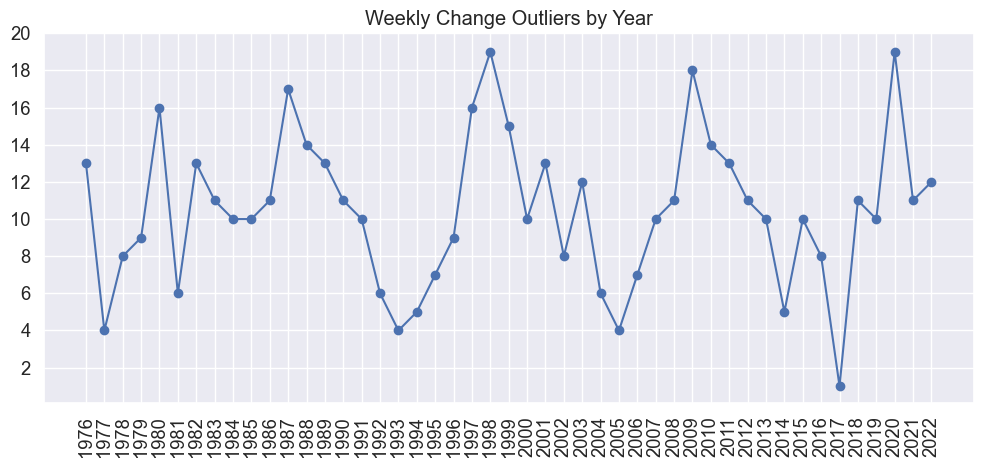

In [1164]:
# Plot the positive outliers by year
f = plt.figure()
# Extra width to fit all the information
f.set_figwidth(12)
f.set_figheight(4.8)
plt.plot(years_w_chg, marker = 'o')
# Show all years
plt.xticks(ticks = range(1976, 2023), rotation = 90)
plt.yticks(ticks = np.arange(2, 22, 2))
plt.title('Weekly Change Outliers by Year')
plt.show()
# Again, 2017 was remarkably tranquil. But we still seem to have chosen well.

The monthly is a little trickier, since unavoidably there will be stretches of years with no enormous monthly performance outliers. Let's look at the median gain for months.

In [1166]:
df_m[df_m.m_chg >= 0].describe()[['gain']]

,gain
count,348.000000
mean,3.339684
std,2.571291
min,0.000000
25%,1.332500
50%,2.805000
75%,4.587500
max,13.170000


The 75th percentile of gains seems too high, but the median is obviously too low. Let's pick 4% as a round number.

In [1167]:
m_chg_cutoff = 4

Okay, now it's time to add these figures into our DataFrames.

In [1168]:
# Add outlier column for daily DataFrame
df['outlier'] = df['day_chg'] >= d_chg_cutoff
df.head()

,close,FFR,close_1d,day_chg,gain,weekday,outlier
DATE,,,,,,,
1976-01-02,90.9,5.28,NaN,NaN,NaN,5,False
1976-01-05,92.6,5.29,90.9,1.87,1.87,1,True
1976-01-06,93.5,5.05,92.6,0.97,0.97,2,False
1976-01-07,93.9,4.26,93.5,0.43,0.43,3,False
1976-01-08,94.6,4.84,93.9,0.75,0.75,4,False


In [1169]:
# Add outlier column for weekly DataFrame
df_w['outlier'] = df_w['wk_chg'] >= w_chg_cutoff
df_w.head(10)

,close,FFR,weekday,close_1w,wk_chg,gain,outlier
DATE,,,,,,,
1976-01-04,90.9,5.28,5,NaN,NaN,NaN,False
1976-01-11,94.9,4.73,5,90.9,4.40,4.40,True
1976-01-18,97.0,4.82,5,94.9,2.21,2.21,True
1976-01-25,99.2,4.72,5,97.0,2.27,2.27,True
1976-02-01,100.9,4.84,5,99.2,1.71,1.71,True
1976-02-08,99.5,4.76,5,100.9,-1.39,0.00,False
1976-02-15,99.7,4.80,5,99.5,0.20,0.20,False
1976-02-22,102.1,4.73,5,99.7,2.41,2.41,True
1976-02-29,99.7,4.89,5,102.1,-2.35,0.00,False


In [1170]:
df_m['outlier'] = df_m['m_chg'] >= m_chg_cutoff
df_m.head(10)

,close,FFR,close_1m,m_chg,gain,outlier
DATE,,,,,,
1976-01-31,100.9,4.84,NaN,NaN,NaN,False
1976-02-29,99.7,4.89,100.9,-1.19,0.00,False
1976-03-31,102.8,5.07,99.7,3.11,3.11,False
1976-04-30,101.6,5.10,102.8,-1.17,0.00,False
1976-05-31,100.2,5.67,101.6,-1.38,0.00,False
1976-06-30,104.3,5.71,100.2,4.09,4.09,True
1976-07-31,103.4,5.32,104.3,-0.86,0.00,False
1976-08-31,102.9,5.31,103.4,-0.48,0.00,False
1976-09-30,105.2,5.31,102.9,2.24,2.24,False


Nice! Now we know what a large, outsized move in stocks is, on a daily, weekly, and monthly basis.

### Determine thresholds for the FFR

Let's now determine the thresholds for the FFR. What defines a low interest rate period versus a high interest rate period? For our daily data, we can create bins with intuitive thresholds, rather than dividing evenly.

In [1173]:
# Manually define bins for daily data
bins = pd.IntervalIndex.from_tuples([(df.FFR.min(), 0.5), (0.5, 2), (2, 3.5), (3.5, 5), (5, 7), (7, 10), (10, df.FFR.max())])
# View the results
pd.cut(df.FFR, bins = bins).value_counts()

(5.0, 7.0]       2775
(0.04, 0.5]      2576
(7.0, 10.0]      1739
(0.5, 2.0]       1473
(3.5, 5.0]       1174
(2.0, 3.5]       1097
(10.0, 22.36]    1014
Name: FFR, dtype: int64

There are over 1,000 data points in each bin, the bins are intuitive, and they isolate both the ultra-low interest rates of the late 2000s and the ultra-high rates of the early 1980s. We can go with this.

In [1174]:
# Add the discretized bin values to the DataFrame
df['FFR_bin'] = pd.cut(df.FFR, bins = bins).values
df.head()

,close,FFR,close_1d,day_chg,gain,weekday,outlier,FFR_bin
DATE,,,,,,,,
1976-01-02,90.9,5.28,NaN,NaN,NaN,5,False,"(5.0, 7.0]"
1976-01-05,92.6,5.29,90.9,1.87,1.87,1,True,"(5.0, 7.0]"
1976-01-06,93.5,5.05,92.6,0.97,0.97,2,False,"(5.0, 7.0]"
1976-01-07,93.9,4.26,93.5,0.43,0.43,3,False,"(3.5, 5.0]"
1976-01-08,94.6,4.84,93.9,0.75,0.75,4,False,"(3.5, 5.0]"


This is good because it gives us a sample size of near or greater than 1,000 for each bin, but there are also enough bins to differentiate between merely "low", "medium", and "high" rates.

In [1175]:
# Add a lagging value to show beginning of period indicator => end of period market return
# Comparison will now be <end of previous day> to <end of today>
df['FFR_bin_1d'] = df['FFR_bin'].shift(periods = 1)

For week data, we have fewer data points, so a smaller number of bins will provide more valid findings.

In [1178]:
# Manually define bins for weekly data
bins_w = pd.IntervalIndex.from_tuples([(df_w.FFR.min(), 1.5), (1.5, 4), (4, 5.5), (5.5, 8), (8, df_w.FFR.max())])
# View the results
pd.cut(df_w.FFR, bins = bins_w).value_counts()

(0.04, 1.5]     710
(8.0, 20.61]    471
(4.0, 5.5]      449
(1.5, 4.0]      423
(5.5, 8.0]      399
Name: FFR, dtype: int64

Another pretty even and intuitive distribution.

In [1179]:
# Add the discretized bin values to the DataFrame
df_w['FFR_bin'] = pd.cut(df_w.FFR, bins = bins_w).values
df_w.head()

,close,FFR,weekday,close_1w,wk_chg,gain,outlier,FFR_bin
DATE,,,,,,,,
1976-01-04,90.9,5.28,5,NaN,NaN,NaN,False,"(4.0, 5.5]"
1976-01-11,94.9,4.73,5,90.9,4.40,4.40,True,"(4.0, 5.5]"
1976-01-18,97.0,4.82,5,94.9,2.21,2.21,True,"(4.0, 5.5]"
1976-01-25,99.2,4.72,5,97.0,2.27,2.27,True,"(4.0, 5.5]"
1976-02-01,100.9,4.84,5,99.2,1.71,1.71,True,"(4.0, 5.5]"


In [1180]:
# Add a lagging value to show beginning of period indicator => end of period market return
# Comparison will now be <end of previous week> to <end of this week>
df_w['FFR_bin_1w'] = df_w['FFR_bin'].shift(periods = 1)

For monthly data, we already have a very low sample size, so we should divide just about evenly. Let's take a look at what Pandas comes up with for quartiles.

In [1182]:
pd.qcut(df_m.FFR, 4).value_counts()

(0.039, 1.058]    141
(1.058, 4.725]    141
(4.725, 6.892]    141
(6.892, 22.0]     141
Name: FFR, dtype: int64

And make some slight modifications...

In [1183]:
# Manually define bins for monthly data
bins_m = pd.IntervalIndex.from_tuples([(df_m.FFR.min(), 1), (1, 4.5), (4.5, 7), (7, df_m.FFR.max())])
# Add the discretized bin values to the DataFrame
df_m['FFR_bin'] = pd.cut(df_m.FFR, bins = bins_m).values
df_m.head()

,close,FFR,close_1m,m_chg,gain,outlier,FFR_bin
DATE,,,,,,,
1976-01-31,100.9,4.84,NaN,NaN,NaN,False,"(4.5, 7.0]"
1976-02-29,99.7,4.89,100.9,-1.19,0.00,False,"(4.5, 7.0]"
1976-03-31,102.8,5.07,99.7,3.11,3.11,False,"(4.5, 7.0]"
1976-04-30,101.6,5.10,102.8,-1.17,0.00,False,"(4.5, 7.0]"
1976-05-31,100.2,5.67,101.6,-1.38,0.00,False,"(4.5, 7.0]"


In [1184]:
# Add a lagging value to show beginning of period indicator => end of period market return
# Comparison will now be <end of previous month> to <end of this month>
df_m['FFR_bin_1m'] = df_m['FFR_bin'].shift(periods = 1)

Now bins have been added to determine thresholds for the FFR. And with that, the data manipulation part of our project concludes, and we can go on to our findings!

## Analysis and Findings

### 1. What is the overall Federal Funds Rate (FFR)'s relationship with stock returns, on a daily, weekly, and monthly basis?

#### DAILY BASIS

In [1187]:
df.head()

,close,FFR,close_1d,day_chg,gain,weekday,outlier,FFR_bin,FFR_bin_1d
DATE,,,,,,,,,
1976-01-02,90.9,5.28,NaN,NaN,NaN,5,False,"(5.0, 7.0]",NaN
1976-01-05,92.6,5.29,90.9,1.87,1.87,1,True,"(5.0, 7.0]","(5.0, 7.0]"
1976-01-06,93.5,5.05,92.6,0.97,0.97,2,False,"(5.0, 7.0]","(5.0, 7.0]"
1976-01-07,93.9,4.26,93.5,0.43,0.43,3,False,"(3.5, 5.0]","(5.0, 7.0]"
1976-01-08,94.6,4.84,93.9,0.75,0.75,4,False,"(3.5, 5.0]","(3.5, 5.0]"


In [1188]:
round(df.groupby(by = 'FFR_bin_1d').mean(), 4)[['close', 'FFR', 'day_chg', 'gain']]

,close,FFR,day_chg,gain
FFR_bin_1d,,,,
"(0.04, 0.5]",2036.5582,0.1488,0.0595,0.4403
"(0.5, 2.0]",1794.3285,1.3789,-0.0027,0.4267
"(2.0, 3.5]",1442.5811,2.7481,0.0017,0.3318
"(3.5, 5.0]",919.7513,4.4198,0.0199,0.3457
"(5.0, 7.0]",728.3470,5.7947,0.0533,0.3851
"(7.0, 10.0]",222.9888,8.5822,0.0626,0.3746
"(10.0, 22.36]",123.8903,13.4858,0.0115,0.3386


This rudimentary initial analysis shows that the best average returns occur in the 0 to 50 bps interest rate bin. Increasing the likelihood of statistical significance is the fact that returns average flat to nearly flat over the next three bins, even falling below zero in the case of the 50 to 200 bps bin. Interestingly, they become high again starting at the 5% bin.

However, when we account for the fact that most of the 5+% rates occurred before 2000, when economic growth was stronger, the numbers are damning for non-low interest rates.

When examining average gains, the pattern holds as well, although between 50 and 200 bps is also strong. The dead zone seems to be between 200 and 500, even though low outliers that could have skewed the average have been taken out.

Let's run t-tests to see the significance of these findings.

In [1189]:
from scipy.stats import ttest_ind
# Select days with rates in the very low and very high bins
df_tt_1 = df[df.FFR_bin_1d.isin([pd.Interval(0.04, 0.5, closed = 'right'),\
                                pd.Interval(5.0, 7.0, closed = 'right'),\
                                pd.Interval(7.0, 10.0, closed = 'right'),\
                                pd.Interval(10.0, 22.0, closed = 'right')])]
# Select days with rates between 50 and 500 bps
df_tt_2 = df[df.FFR_bin_1d.isin([pd.Interval(0.5, 2.0, closed = 'right'),\
                                pd.Interval(2.0, 3.5, closed = 'right'),\
                                pd.Interval(3.5, 5.0, closed = 'right')])]
# Run a t-test 
ttest_ind(df_tt_1.day_chg[1:], df_tt_2.day_chg[1:])

Ttest_indResult(statistic=2.293254171909554, pvalue=0.021852444915824425)

This is a strong and statistically significant finding.

In [1190]:
# Select days with rates in the high gain range
df_tt_3 = df[df.FFR_bin_1d.isin([pd.Interval(0.04, 0.5, closed = 'right'),\
                                pd.Interval(0.5, 2.0, closed = 'right')])]
# Select days with rates in the low gain range (exclusive due to binning procedures)
df_tt_4 = df[~df.FFR_bin_1d.isin([pd.Interval(0.04, 0.5, closed = 'right'),\
                                pd.Interval(0.5, 2.0, closed = 'right')])]
# Run a t-test 
ttest_ind(df_tt_3.gain[1:], df_tt_4.gain[1:])

Ttest_indResult(statistic=5.513090614572176, pvalue=3.5996917979273946e-08)

In this case, the p-value is even more convincing, however, since we are capturing average gain only, values may be skewed by the presence of days that were simply more volatile. Still, we're finding powerful correlations here.

Let's move on and make some plots.

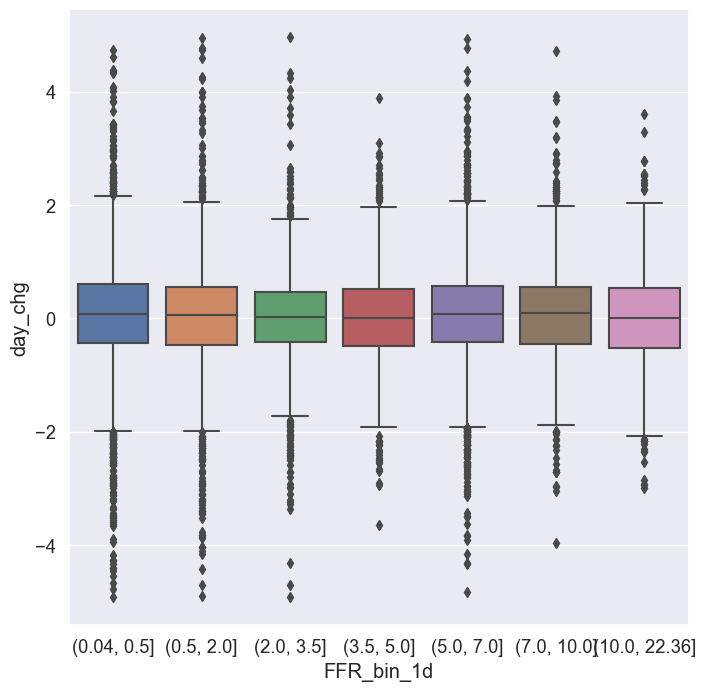

In [1192]:
# Set a style to enlarge plots
sns.set(rc= {'figure.figsize':(8,8)}, font_scale = 1.2, style = 'darkgrid')
# Add a boxplot for day change, removing extreme values
sns.boxplot(data = df[(df.day_chg >= -5) & (df.day_chg <= 5)],\
            x = 'FFR_bin_1d', y = 'day_chg')
plt.show()

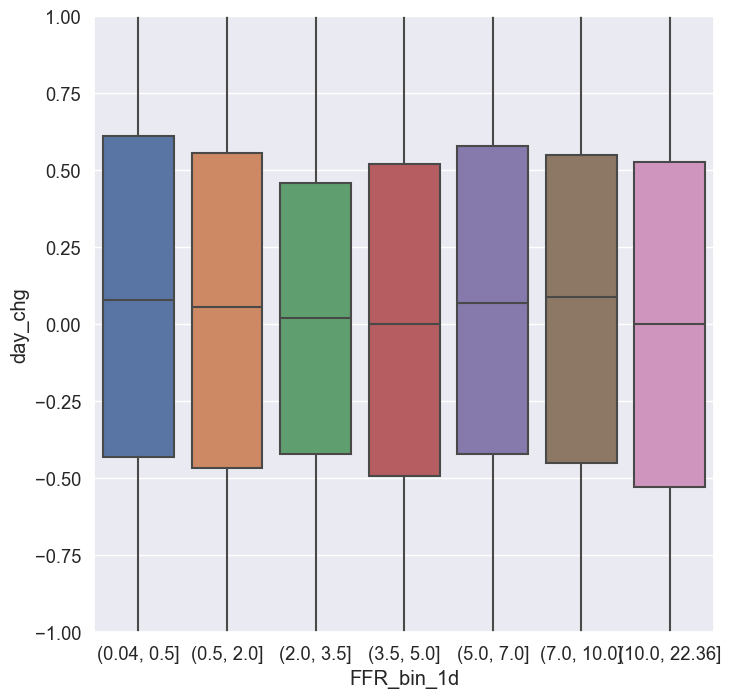

In [1193]:
# The same plot, but zoomed in
sns.boxplot(data = df[(df.day_chg >= -5) & (df.day_chg <= 5)],\
            x = 'FFR_bin_1d', y = 'day_chg')
plt.ylim(-1, 1)
plt.show()

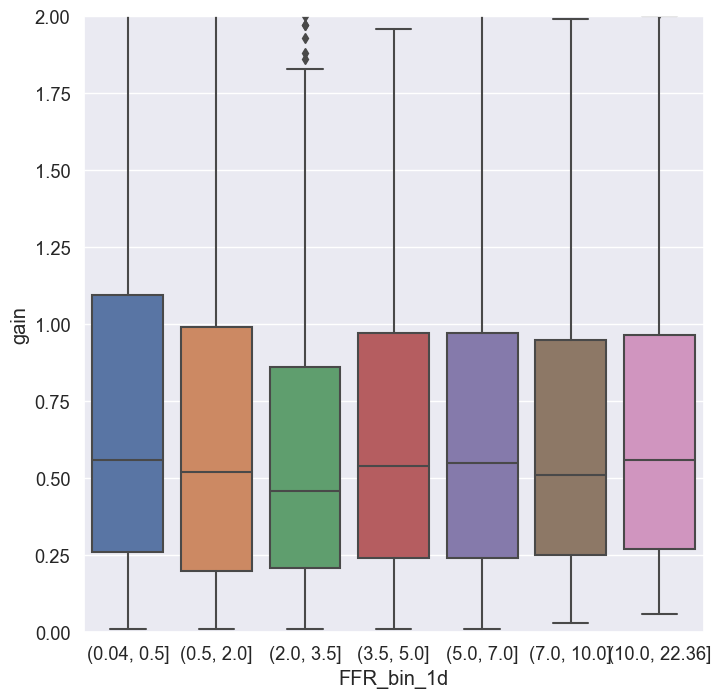

In [1194]:
# Take a look at gains
sns.boxplot(data = df[df.gain > 0], x = 'FFR_bin_1d', y = 'gain')
plt.ylim(0, 2)
plt.show()

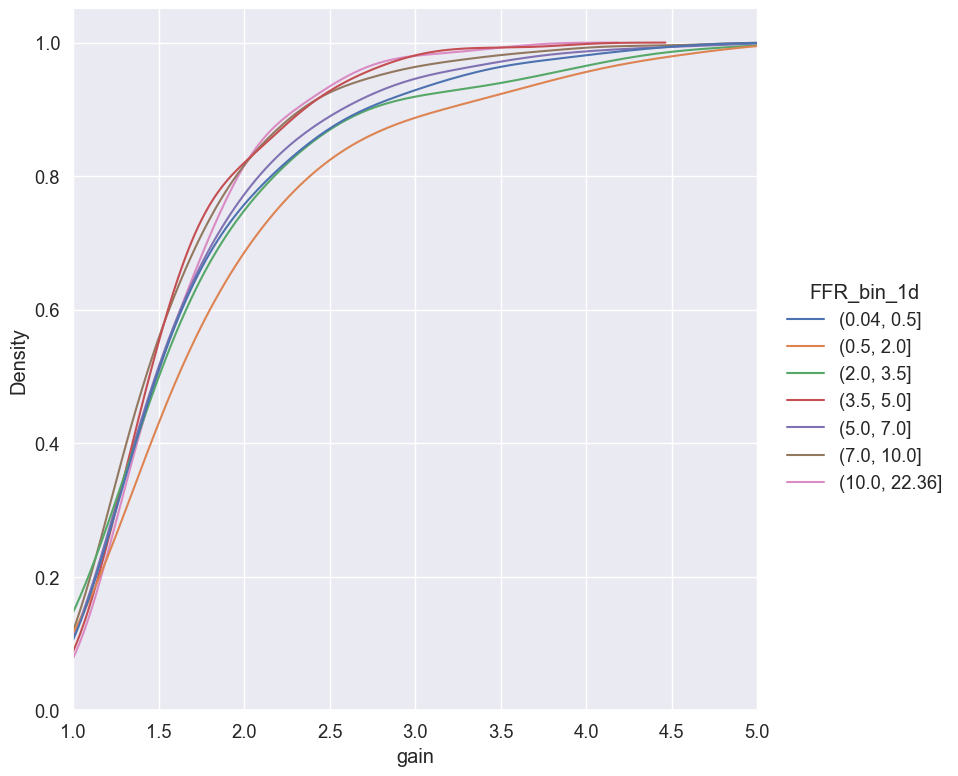

In [1195]:
# Make a kde plot of gain distribution by FFR, 1-5%
sns.displot(data = df[(df.gain > 1) & (df.gain < 5)], x = 'gain', kind = 'kde', hue = 'FFR_bin_1d',\
            cumulative = True, common_norm = False, height = 8)
plt.xlim(1, 5)
plt.show()

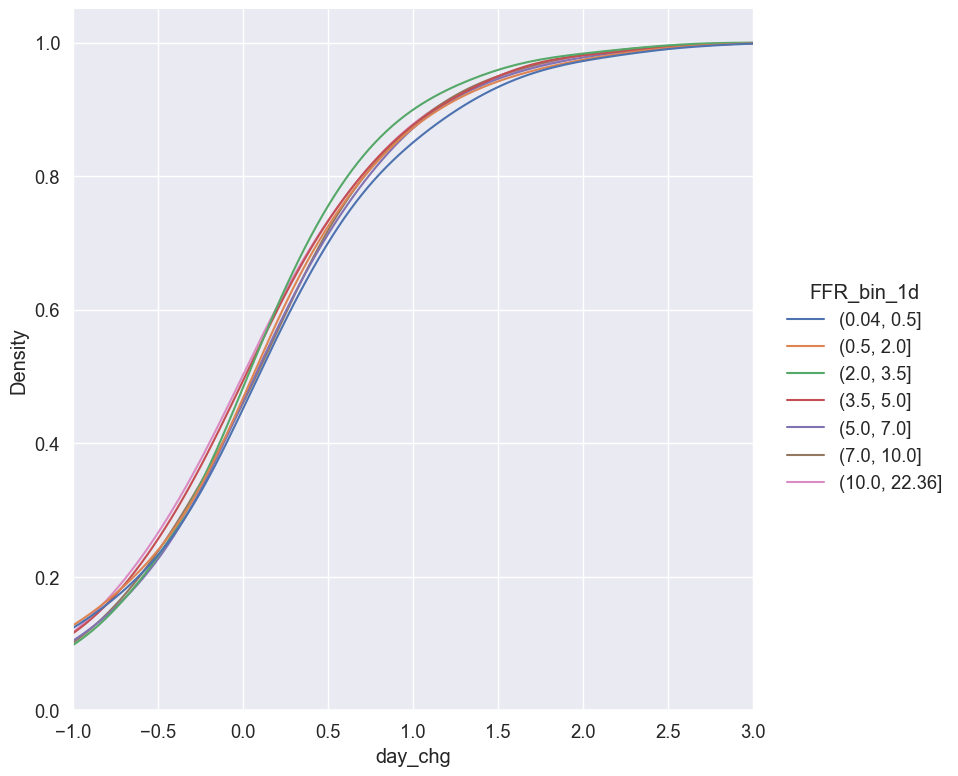

In [1196]:
# Make a kde plot of overall change by FFR
sns.displot(data = df[(df.day_chg >= -3) & (df.day_chg <= 3)],\
            x = 'day_chg', kind = 'kde', hue = 'FFR_bin_1d', cumulative = True, common_norm = False, height = 8)
plt.xlim(-1, 3)
plt.show()

We've learned some interesting things from these plots.

<ol>
    <li>Rates between 0 and 50 bps, as well as between 500 and 1000, have noticeably better median results.</li>
    <li>These same rate brackets also have markedly increased high-percentile gains.</li>
    <li>Returns decay as we move up in rates (until the 350 bps mark), for both total returns and gains, and the decay is consistent.</li>
    <li>Plotting the CDF of gains is less clear, but it also favors lower values.</li>
    <li>Plotting the CDF of day change demonstrates a yawning advantage for the 0-50 bps range, particularly in the 0.5-1.5% market return range.</li>
</ol>

In summary, lower and higher interest rates seem to lead to improved returns, and medium interest rates poorer ones. It is easy to understand why the lower rates could be favorable, and why medium rates could not&mdash;low rates are a known stimulant for asset buyers, and medium rates often dampen risky investments by offering an attractive alternative. What's less clear is why high rates are so good. It may simply have to do with the fact that most of them took place in the 1980s, when the stock market was famously positive...

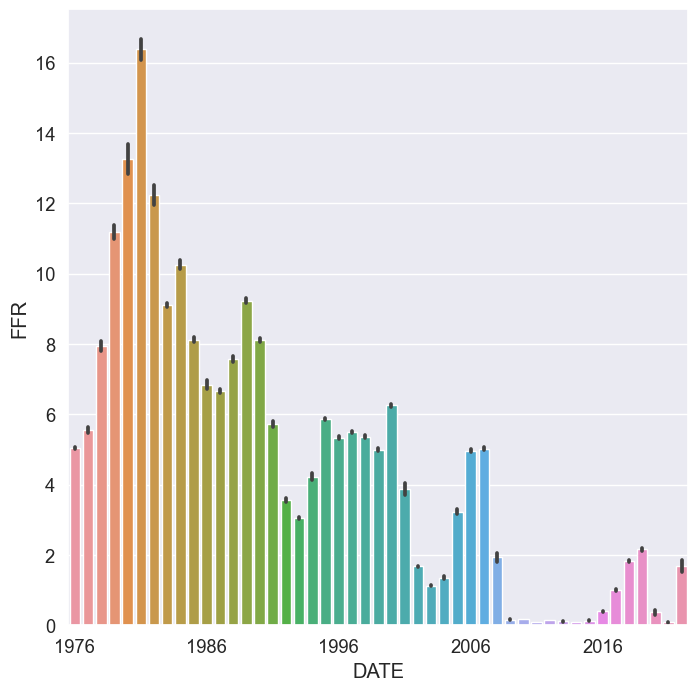

In [1197]:
ax = sns.barplot(data = df, x = df.index.year, y = 'FFR')
new_ticks = [i.get_text() for i in ax.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 10), new_ticks[::10])
plt.show()

#### WEEKLY BASIS

In [1198]:
df_w.head()

,close,FFR,weekday,close_1w,wk_chg,gain,outlier,FFR_bin,FFR_bin_1w
DATE,,,,,,,,,
1976-01-04,90.9,5.28,5,NaN,NaN,NaN,False,"(4.0, 5.5]",NaN
1976-01-11,94.9,4.73,5,90.9,4.40,4.40,True,"(4.0, 5.5]","(4.0, 5.5]"
1976-01-18,97.0,4.82,5,94.9,2.21,2.21,True,"(4.0, 5.5]","(4.0, 5.5]"
1976-01-25,99.2,4.72,5,97.0,2.27,2.27,True,"(4.0, 5.5]","(4.0, 5.5]"
1976-02-01,100.9,4.84,5,99.2,1.71,1.71,True,"(4.0, 5.5]","(4.0, 5.5]"


In [1199]:
round(df_w.groupby(by = 'FFR_bin_1w').mean(), 4)[['close', 'FFR', 'wk_chg', 'gain']]

,close,FFR,wk_chg,gain
FFR_bin_1w,,,,
"(0.04, 1.5]",1951.6914,0.3812,0.1955,0.9795
"(1.5, 4.0]",1539.9703,2.5953,0.0251,0.7845
"(4.0, 5.5]",888.4509,5.0201,0.2224,0.8921
"(5.5, 8.0]",487.8246,6.5033,0.2542,0.9836
"(8.0, 20.61]",177.8921,10.9466,0.1827,0.9038


The simple means seem to bolster our hypothesis that gains by FFR show an inverse parabolic distribution. In other words, the low and high interest bins have the highest returns, while the middle lags. This is true in both absolute change and average gain (although far weaker in average gain).

Let's run t-tests to see the significance of these findings.

In [1202]:
# Select weeks with rates between 150 and 400 bps
df_tt_1 = df_w[df_w.FFR_bin_1w.isin([pd.Interval(1.5, 4.0, closed = 'right')])]
# Select all other weeks
df_tt_2 = df_w[~df_w.FFR_bin_1w.isin([pd.Interval(1.5, 4.0, closed = 'right')])]
# Run a t-test on week change
print("Weekly change t-test:", ttest_ind(df_tt_1.wk_chg[1:], df_tt_2.wk_chg[1:]))
print("Average gain t-test:", ttest_ind(df_tt_3.gain[1:], df_tt_4.gain[1:]))

Weekly change t-test: Ttest_indResult(statistic=-1.547656845795771, pvalue=0.12183414425744826)
Average gain t-test: Ttest_indResult(statistic=5.513090614572176, pvalue=3.5996917979273946e-08)


The p-value for average isn't overpowering, but given the same pattern also existed in daily data, we may be onto something here.

Let's move on and make some plots.

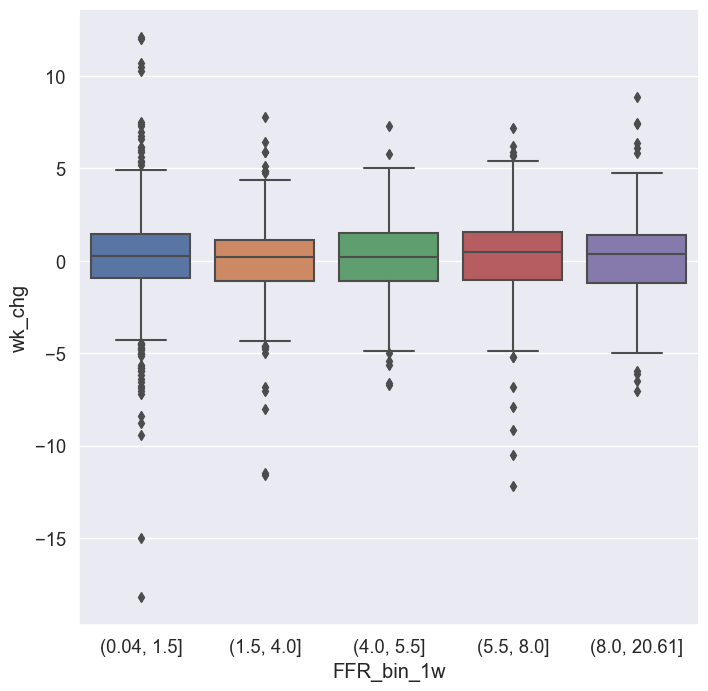

In [1203]:
# Add a boxplot for weekly change
sns.boxplot(data = df_w, x = 'FFR_bin_1w', y = 'wk_chg')
plt.show()

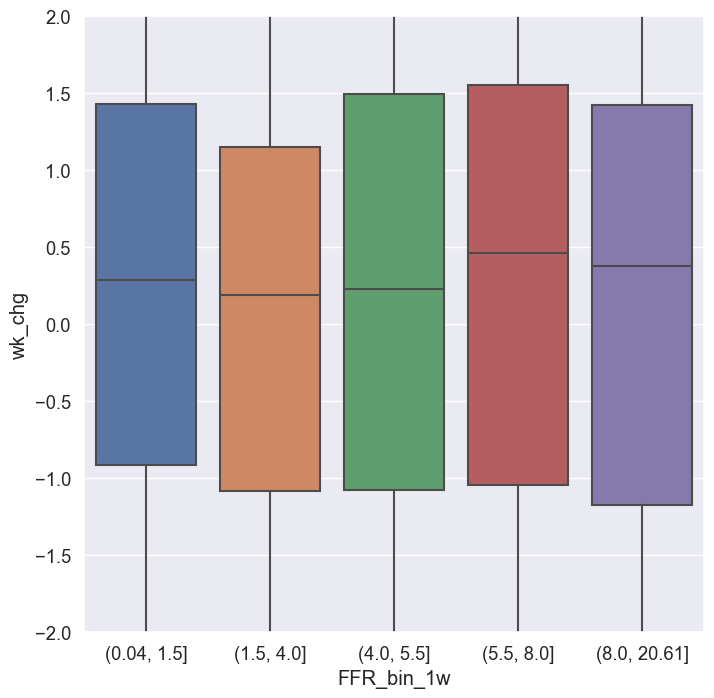

In [1204]:
# A zoomed in version of the same plot
sns.boxplot(data = df_w, x = 'FFR_bin_1w', y = 'wk_chg')
plt.ylim(-2, 2)
plt.show()

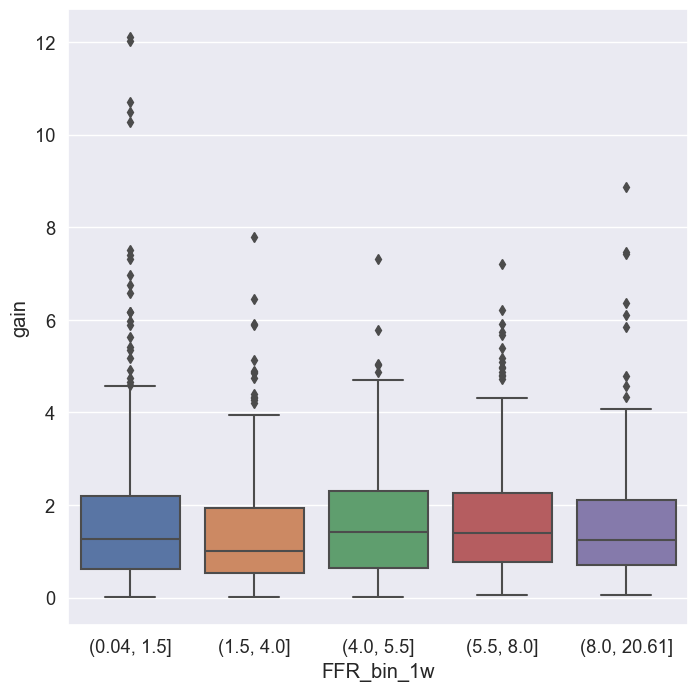

In [1205]:
# Plot of gains
sns.boxplot(data = df_w[df_w.gain > 0], x = 'FFR_bin_1w', y = 'gain')
plt.show()

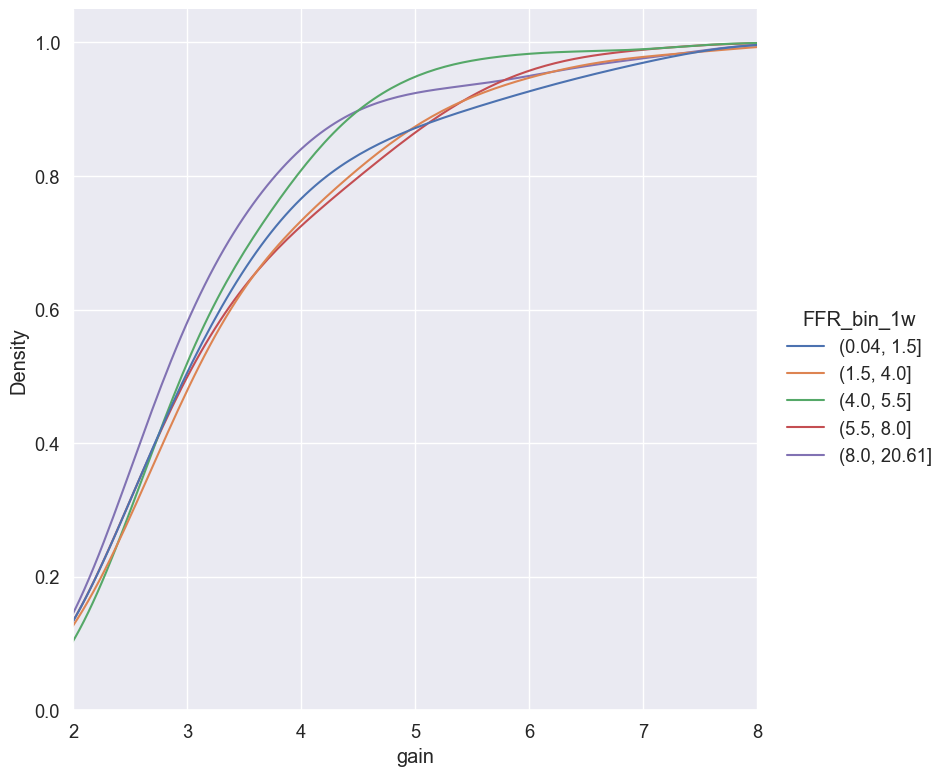

In [1206]:
# Make a kde plot of gain distribution by FFR, 2-8%
sns.displot(data = df_w[(df_w.gain >= 2) & (df_w.gain <= 8)], x = 'gain', kind = 'kde', hue = 'FFR_bin_1w',\
            cumulative = True, common_norm = False, height = 8)
plt.xlim(2, 8)
plt.show()

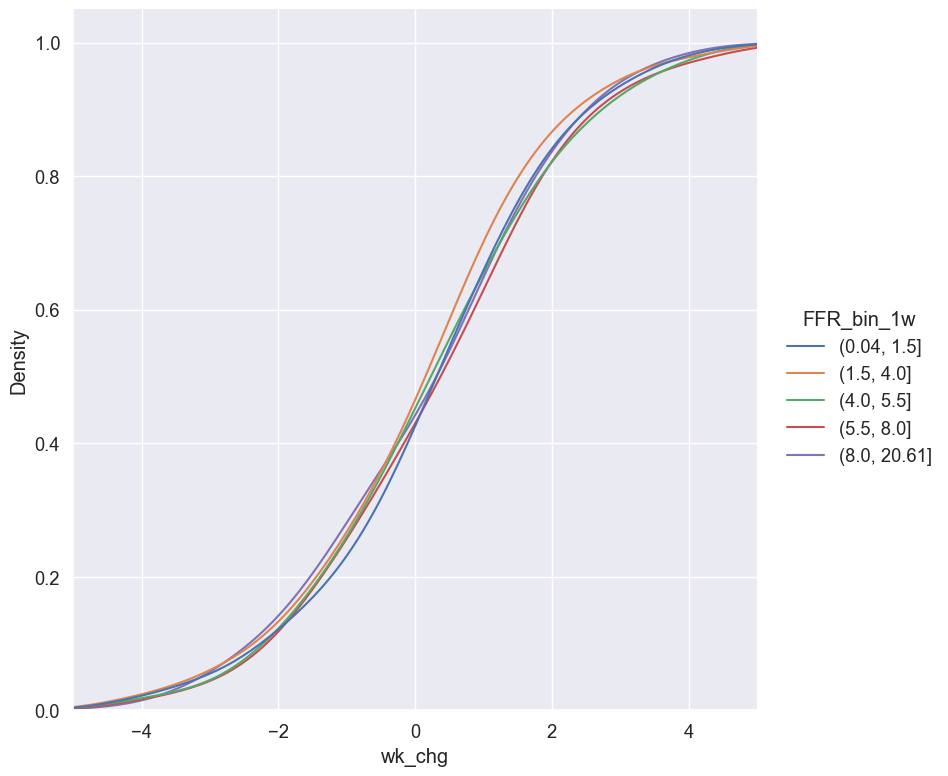

In [1207]:
# Make a kde plot of overall change by FFR
sns.displot(data = df_w[(df_w.wk_chg >= -5) & (df_w.wk_chg <= 5)],\
            x = 'wk_chg', kind = 'kde', hue = 'FFR_bin_1w', cumulative = True, common_norm = False, height = 8)
plt.xlim(-5, 5)
plt.show()

Here's what we've learned from the weekly plots:

<ol>
    <li>Rates between 0 and 150 bps, not only beat the 150 to 400 bps moderate range around the center...</li>
    <li>...but also have a much higher 1Q, far fewer negative outliers and far more positive outliers.</li>
    <li>There is little difference between the 0 to 150 bracket and the higher brackets. The 150-400 bracket alone is the laggard.</li>
    <li>Plotting the CDF of day change further clarifies this pattern, although some noise is added by the higher brackets.</li>
</ol>

So, the trend has continued: low interest rates and high interest beat medium interest rates. What about those outliers? Let's take a look...

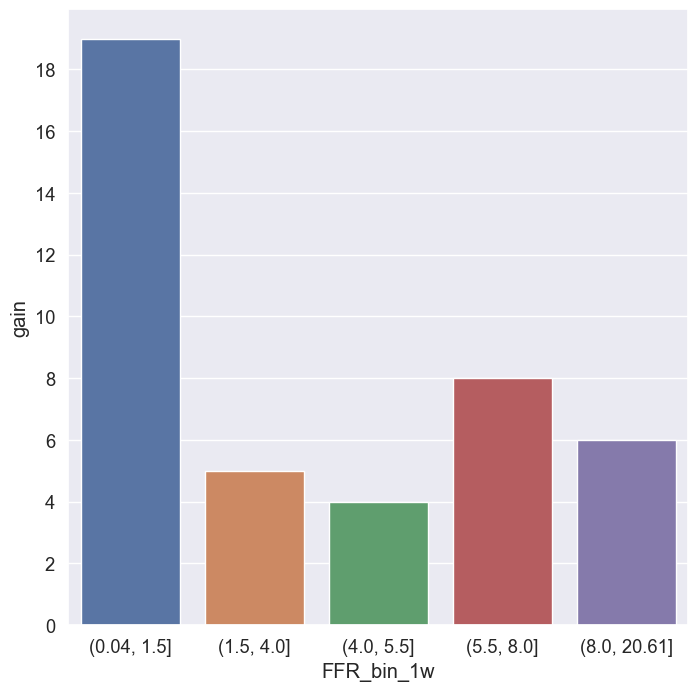

In [1208]:
# For 5+% outliers, pivot by FFR_bin and gain, and plot
sns.barplot(data = df_w[df_w.wk_chg >= 5].pivot_table(index = 'FFR_bin_1w', values = 'gain', aggfunc = 'count').reset_index(),\
            x = 'FFR_bin_1w', y = 'gain')
plt.yticks(np.arange(0, 20, 2))
plt.show()

While sample size is small, it is interesting that these results follow our overall trend of exciting returns in the low and high FFR brackets and dull returns in the middle brackets. In particular, low interest rates lead to a large number of positive outliers.

#### MONTHLY BASIS

In [1209]:
df_m.head()

,close,FFR,close_1m,m_chg,gain,outlier,FFR_bin,FFR_bin_1m
DATE,,,,,,,,
1976-01-31,100.9,4.84,NaN,NaN,NaN,False,"(4.5, 7.0]",NaN
1976-02-29,99.7,4.89,100.9,-1.19,0.00,False,"(4.5, 7.0]","(4.5, 7.0]"
1976-03-31,102.8,5.07,99.7,3.11,3.11,False,"(4.5, 7.0]","(4.5, 7.0]"
1976-04-30,101.6,5.10,102.8,-1.17,0.00,False,"(4.5, 7.0]","(4.5, 7.0]"
1976-05-31,100.2,5.67,101.6,-1.38,0.00,False,"(4.5, 7.0]","(4.5, 7.0]"


In [1210]:
round(df_m.groupby(by = 'FFR_bin_1m').mean(), 4)[['close', 'FFR', 'm_chg', 'gain']]

,close,FFR,m_chg,gain
FFR_bin_1m,,,,
"(0.04, 1.0]",2080.2085,0.1852,1.0666,2.2501
"(1.0, 4.5]",1496.5460,2.4836,-0.1285,1.5633
"(4.5, 7.0]",753.1367,5.7719,1.0080,2.1580
"(7.0, 22.0]",199.4272,10.5086,0.9787,2.2644


Once again, the numbers reinforce the theory that low and high FFRs are the best for stock returns. Somewhat shockingly, the average return for the 100-450 bps range is a loss. Given the impressive vertical trajectory of the stock market since 1976, this low average monthly change is perhaps the most significant finding so far, and in terms of trading a significant argument in favor of abandoning this interest rate bracket entirely.

Let's run t-tests to see the significance of these findings.

In [1211]:
# Select days with rates in the high change range (inclusive-exclusive due to binning procedures)
df_tt_1 = df_m[df_m.FFR_bin_1m.isin([pd.Interval(1.0, 4.5, closed = 'right')])]
# Select days with rates between 100 and 450 bps (exclusive-inclusive due to binning procedures)
df_tt_2 = df_m[~df_m.FFR_bin_1m.isin([pd.Interval(1.0, 4.5, closed = 'right')])]
# Run a t-test on monthly change
print("Monthly change t-test:", ttest_ind(df_tt_1.m_chg[1:], df_tt_2.m_chg[1:]))
print("Average gain t-test:", ttest_ind(df_tt_3.gain[1:], df_tt_4.gain[1:]))

Monthly change t-test: Ttest_indResult(statistic=-2.624865816557206, pvalue=0.008905031334608801)
Average gain t-test: Ttest_indResult(statistic=5.513090614572176, pvalue=3.5996917979273946e-08)


The p-values are the most overpowering yet even given the small sample size!

Let's move on and make some plots.

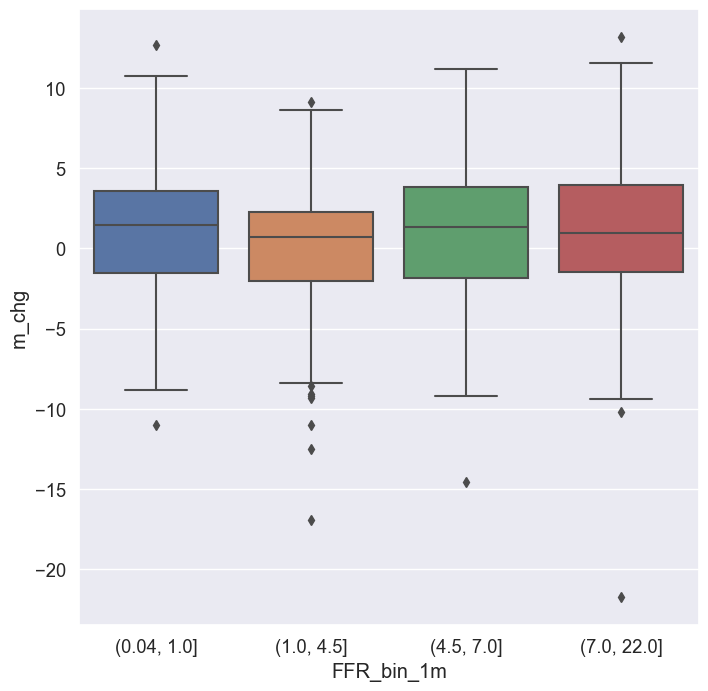

In [1212]:
# Add a boxplot for monthly change
sns.boxplot(data = df_m, x = 'FFR_bin_1m', y = 'm_chg')
plt.show()

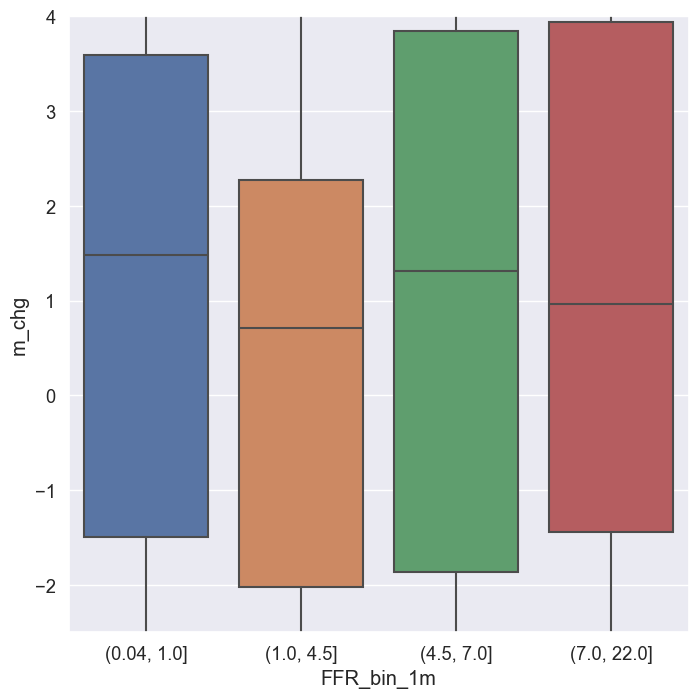

In [1213]:
# The same plot, but zoomed in
sns.boxplot(data = df_m, x = 'FFR_bin_1m', y = 'm_chg')
plt.ylim(-2.5, 4)
plt.show()

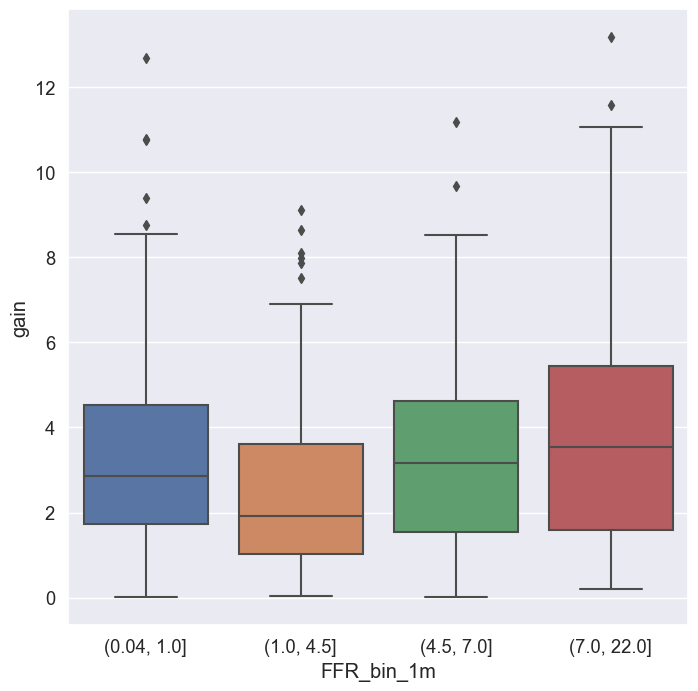

In [1214]:
# Now look at gains
sns.boxplot(data = df_m[df_m.gain > 0], x = 'FFR_bin_1m', y = 'gain')
plt.show()

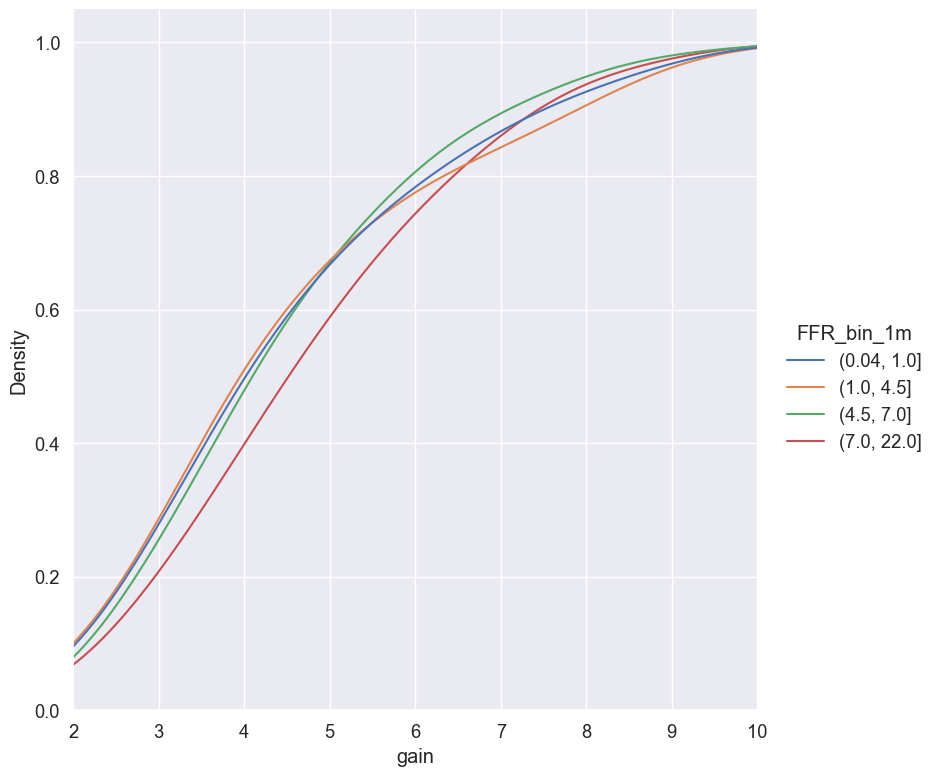

In [1215]:
# Make a kde plot of gain distribution by FFR, 2-10%
sns.displot(data = df_m[(df_m.gain >= 2) & (df_m.gain <= 10)], x = 'gain', kind = 'kde', hue = 'FFR_bin_1m',\
            cumulative = True, common_norm = False, height = 8)
plt.xlim(2, 10)
plt.show()

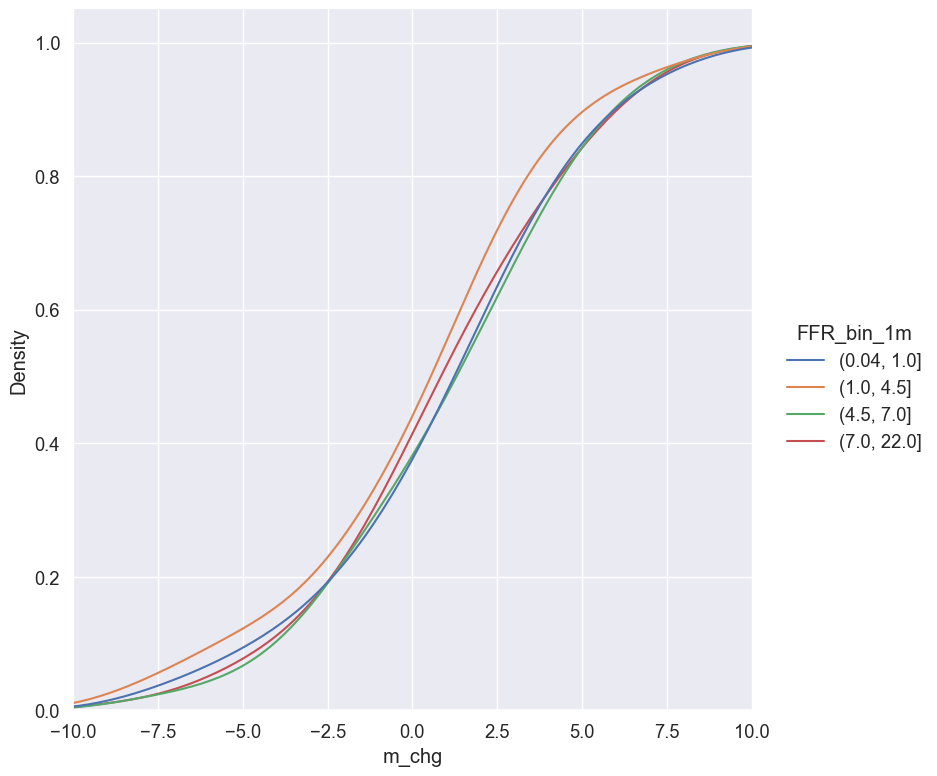

In [1216]:
# Make a kde plot of overall change by FFR
sns.displot(data = df_m[(df_m.m_chg >= -10) & (df_m.m_chg <= 10)],\
            x = 'm_chg', kind = 'kde', hue = 'FFR_bin_1m', cumulative = True, common_norm = False, height = 8)
plt.xlim(-10, 10)
plt.show()

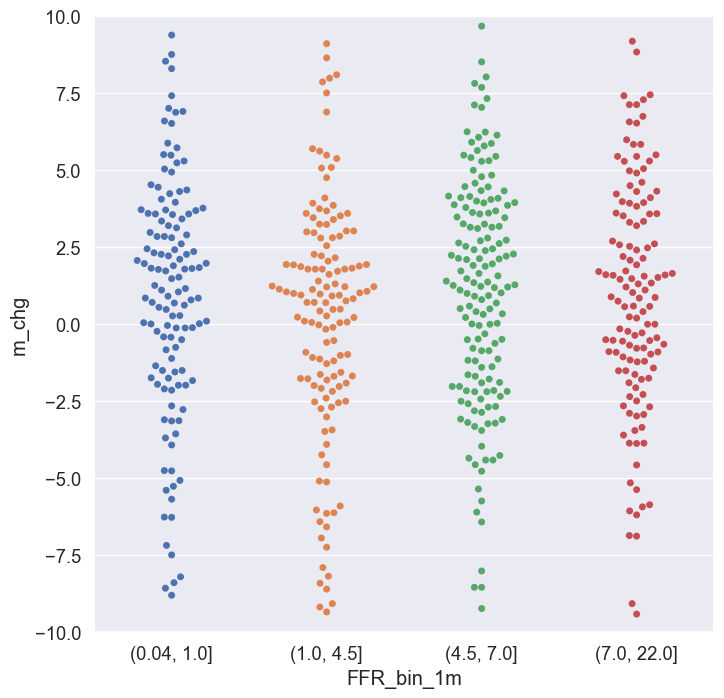

In [1217]:
# We can do a nice swarmplot with a dataset this size, so why not?
sns.swarmplot(data = df_m, x = 'FFR_bin_1m', y = 'm_chg')
plt.ylim(-10, 10)
plt.show()

Here's what we've learned from the monthly plots:

<ol>
    <li>Rates between 0 and 150 bps crush the 150 to 400 bps range with the 3Q being nearly double and the 1Q significantly higher as well.</li>
    <li>Not only is the monthly average far higher, the median gain in the 0 to 150 bps range is about a full percentage point higher!</li>
    <li>The 100-450 bracket possesses nearly all the lowest outliers.</li>
    <li>There is little difference between the 0 to 100 bracket and the higher brackets. The 100-450 bracket alone is the laggard.</li>
    <li>The CDFs continue this trend without revealing any new information.</li>
    <li>The swarmplot reveals the most common returns for the low bracket to be 2-3.5%, and the medium bracket's most common values to be in the 0-2.5% range.</li>
</ol>

Our "parabolic returns" thesis has now been confirmed when broken out by <em>day, week, and month.</em> This is ample information, at least in the world of trading that thrives on tenuous edges.

Now let's move on and see what we can find out about returns' relationship with the FFR's trajectory.

### 2. What is the FFR trajectory's relationship with stock returns, on a daily, weekly, and monthly basis?

#### DAILY BASIS

In [1218]:
# Add a new DataFrame with a lagging value to show beginning of period indicator => end of period market return
# Comparison will now be <end of previous day> to <end of today>
df_t_lead = df.join(df_ffrt.cycle.shift(1))
# Test: we knew hiking began 2022-03-17, so it should start in data 2022-03-18
# Since the previous day was a hike
df_t_lead['2022-03-15':'2022-03-21']

,close,FFR,close_1d,day_chg,gain,weekday,outlier,FFR_bin,FFR_bin_1d,cycle
DATE,,,,,,,,,,
2022-03-15,4262.45,0.08,4173.11,2.14,2.14,2,True,"(0.04, 0.5]","(0.04, 0.5]",Neutral
2022-03-16,4357.86,0.08,4262.45,2.24,2.24,3,True,"(0.04, 0.5]","(0.04, 0.5]",Neutral
2022-03-17,4411.67,0.33,4357.86,1.23,1.23,4,True,"(0.04, 0.5]","(0.04, 0.5]",Neutral
2022-03-18,4463.12,0.33,4411.67,1.17,1.17,5,True,"(0.04, 0.5]","(0.04, 0.5]",Hiking
2022-03-21,4461.18,0.33,4463.12,-0.04,0.00,1,False,"(0.04, 0.5]","(0.04, 0.5]",Hiking


In [1219]:
round(df_t_lead.groupby(by = 'cycle').mean(), 4)

,close,FFR,close_1d,day_chg,gain,weekday,outlier
cycle,,,,,,,
Cutting,762.9999,5.8187,763.0383,0.0488,0.4668,2.9325,0.1275
Hiking,1003.8096,6.3959,1003.8605,0.0052,0.3524,3.0558,0.0901
Neutral,1253.6579,3.6011,1253.0813,0.0474,0.3780,3.0290,0.0955


This is probably the biggest finding yet. Hiking has a very low return, near zero, and also the lowest average and the fewest high outliers. Cutting cycles appear to be the most profitable by far. Let's run a t-test to see if this is statistically significant.

In [1222]:
# Select days where rates are Hiking
df_tt_1 = df_t_lead[df_t_lead.cycle == 'Hiking']
# Select days where rates are not Hiking
df_tt_2 = df_t_lead[df_t_lead.cycle != 'Hiking']
# Run t-tests on day_chg and gain
print("Day change:", ttest_ind(df_tt_1.day_chg[1:], df_tt_2.day_chg[1:]))
print("Gain:", ttest_ind(df_tt_1.gain[1:], df_tt_2.gain[1:]))

Day change: Ttest_indResult(statistic=-1.777996119082936, pvalue=0.0754301309993474)
Gain: Ttest_indResult(statistic=-3.213971889689726, pvalue=0.0013126303543885946)


These findings are very statistically significant, particularly the average gain. Let's make some plots to get a little more clarity.

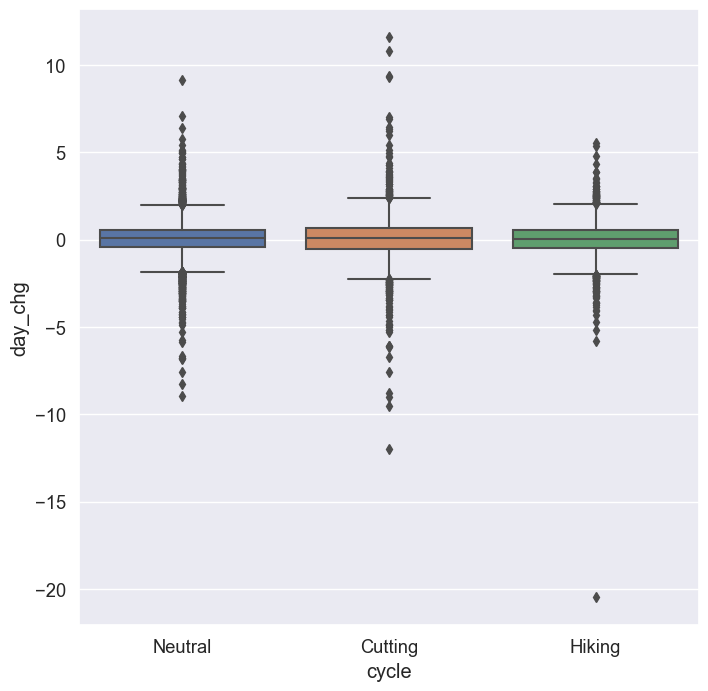

In [1223]:
# Boxplot of week change by cycle
sns.boxplot(data = df_t_lead, x = 'cycle', y = 'day_chg')
plt.show()

This is fascinating. Hiking's highest outlier has never been more than about 6%, while it contains the 1987 Black Monday crash. Meanwhile, Cutting is clearly similar to Neutral, but with far more volatility.

In [1224]:
# Check stats summary with Black Monday removed
round(df_t_lead[df_t_lead.index != '10-19-1987'].groupby(by = 'cycle').mean(), 4)

,close,FFR,close_1d,day_chg,gain,weekday,outlier
cycle,,,,,,,
Cutting,762.9999,5.8187,763.0383,0.0488,0.4668,2.9325,0.1275
Hiking,1004.0883,6.3954,1004.1185,0.0125,0.3526,3.0565,0.0902
Neutral,1253.6579,3.6011,1253.0813,0.0474,0.3780,3.0290,0.0955


In [1225]:
# Check the highest outlier by cycle
df_t_lead.groupby(by = 'cycle').max()[['gain']]

,gain
cycle,
Cutting,11.58
Hiking,5.54
Neutral,9.12


Removing Black Monday didn't make an enormous difference, but this view of the maximum gains is quite jarring. During a Hiking cycle, the market never mustered a gain of more than 5.5%, while even Neutral cycles saw a record of over 9%.

Let's zoom in on the plot for a bit more detail on the central values.

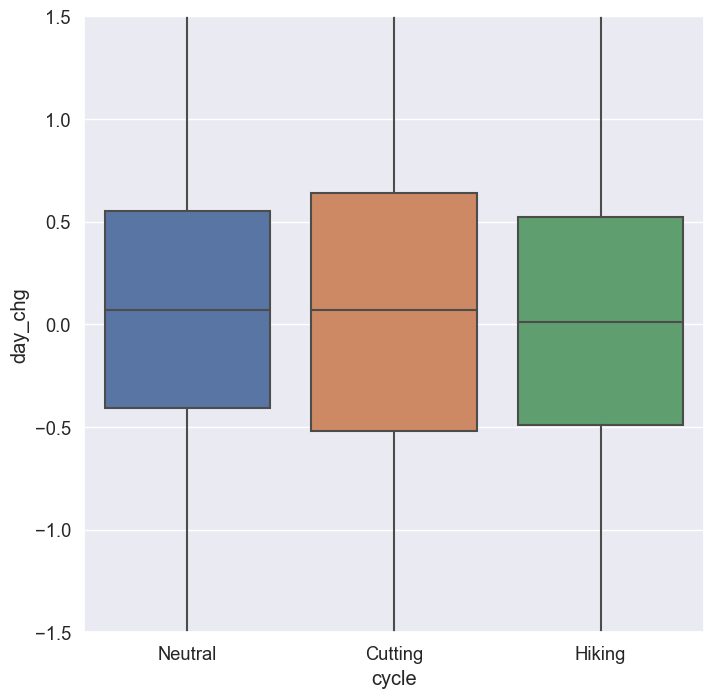

In [1226]:
sns.boxplot(data = df_t_lead, x = 'cycle', y = 'day_chg')
plt.ylim(-1.5, 1.5)
plt.show()

Hiking is clearly the laggard, while Cutting has a similar center to Neutral with quite a bit more volatility.

Now let's plot gains.

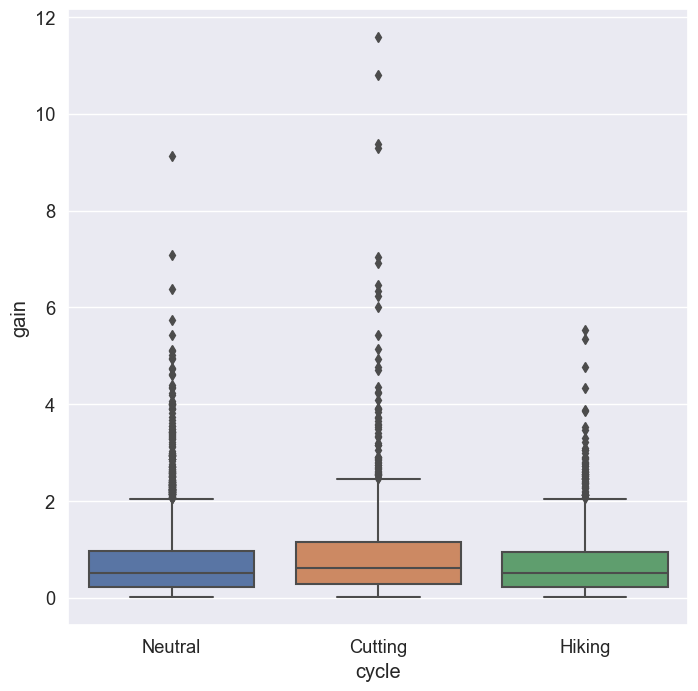

In [1227]:
sns.boxplot(data = df_t_lead[df_t_lead.gain > 0], x = 'cycle', y = 'gain')
plt.show()

Cutting outperforms more clearly here, with most of the highest values, although Neutral also does well. Hiking's returns are quite poor.

It is entirely possible that we should simply avoid Hiking cycles for daily all together. But what about over other time periods?

#### WEEKLY BASIS

In [1230]:
# Add a new DataFrame with a lagging value to show beginning of period indicator => end of period market return
# Comparison will now be <end of previous week> to <end of this week>
df_w_t_lead = df_w.join(df_ffrt.resample('W').last().cycle.shift(1))
# Test: we knew hiking began 2022-03-17 (Thu), so it should start in data 2022-03-27 (Sun)
# Since the previous week featured a hike
df_w_t_lead['2022-03-20':'2022-04-10']

,close,FFR,weekday,close_1w,wk_chg,gain,outlier,FFR_bin,FFR_bin_1w,cycle
DATE,,,,,,,,,,
2022-03-20,4463.12,0.33,5,4204.31,6.16,6.16,True,"(0.04, 1.5]","(0.04, 1.5]",Neutral
2022-03-27,4543.06,0.33,5,4463.12,1.79,1.79,True,"(0.04, 1.5]","(0.04, 1.5]",Hiking
2022-04-03,4545.86,0.33,5,4543.06,0.06,0.06,False,"(0.04, 1.5]","(0.04, 1.5]",Hiking
2022-04-10,4488.28,0.33,5,4545.86,-1.27,0.00,False,"(0.04, 1.5]","(0.04, 1.5]",Hiking


In [1231]:
round(df_w_t_lead.groupby(by = 'cycle').mean(), 4)

,close,FFR,weekday,close_1w,wk_chg,gain,outlier
cycle,,,,,,,
Cutting,749.2771,5.6547,4.9534,748.9852,0.1224,1.0585,0.2369
Hiking,1012.3318,6.5981,4.9669,1012.9626,0.0722,0.8236,0.1710
Neutral,1276.5650,3.4936,4.9677,1273.7356,0.2411,0.9000,0.1981


There are some very serious differences here, between all three categories. Cutting has a low weekly average, but makes up for it with by far the strongest gain and a disproportionate percentage of outliers (around 20% more than the expected 20%). Neutral has the highest average and good numbers. Hiking absolutely lags in all categories.

Let's run t-tests to see just how significant these findings are.

In [1233]:
# Select weeks where rates are Neutral
df_tt_1 = df_w_t_lead[df_w_t_lead.cycle == 'Neutral']
# Select non-Neutral weeks
df_tt_2 = df_w_t_lead[df_w_t_lead.cycle != 'Neutral']
# Select weeks where rates are Hiking
df_tt_3 = df_w_t_lead[df_w_t_lead.cycle == 'Hiking']
# Select non-Hiking weeks
df_tt_4 = df_w_t_lead[df_w_t_lead.cycle != 'Hiking']
# Run t-tests on week change and gain
print("Week change:", ttest_ind(df_tt_1.wk_chg[1:], df_tt_2.wk_chg[1:]))
print("Gain:", ttest_ind(df_tt_3.gain[1:], df_tt_4.gain[1:]))

Week change: Ttest_indResult(statistic=1.5311457530349888, pvalue=0.12586252984647603)
Gain: Ttest_indResult(statistic=-1.7964464488644731, pvalue=0.07254673746013628)


These p-values are near the threshold, although, as we would reasonably expect, higher than the ones for daily values. Neutral thumps the other categories for average return, while Hiking is the clear laggard for gains, with the other two closer together.

Let's make some plots to get a little more clarity.

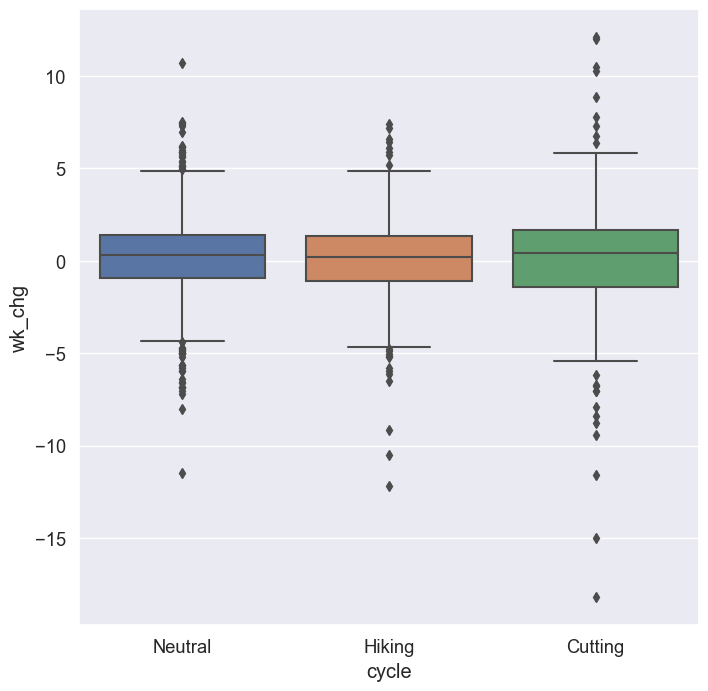

In [1234]:
# Boxplot of week change by cycle
sns.boxplot(data = df_w_t_lead, x = 'cycle', y = 'wk_chg')
plt.show()

This makes Cutting appear simply more volatile than Hiking, with the lowest 1Q, and while it has far more positive outliers, it also has far more negative outliers.

In order to get a clearer view, let's zoom in.

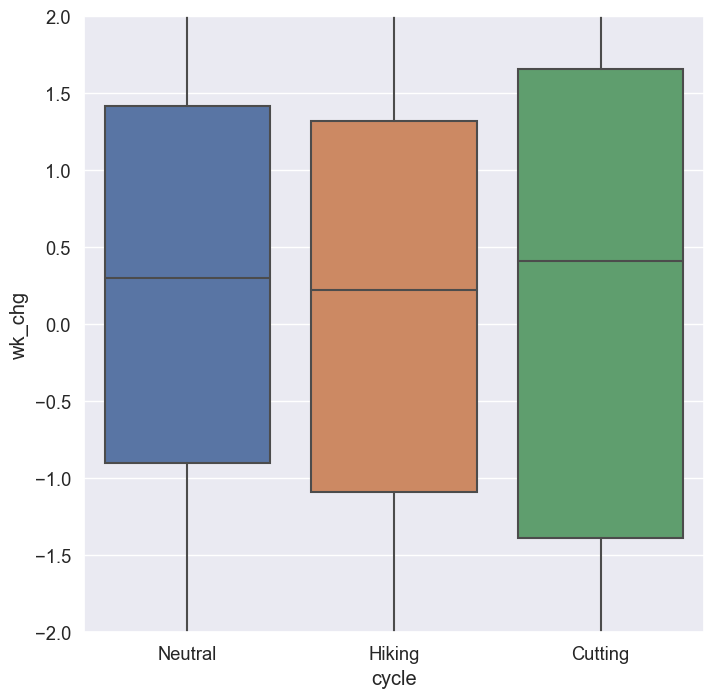

In [1235]:
sns.boxplot(data = df_w_t_lead, x = 'cycle', y = 'wk_chg')
plt.ylim(-2, 2)
plt.show()

Hiking is clearly the laggard, but unlike the analysis of rates, the outperformer, Cutting, also has more volatility to the downside.

Now let's plot gains.

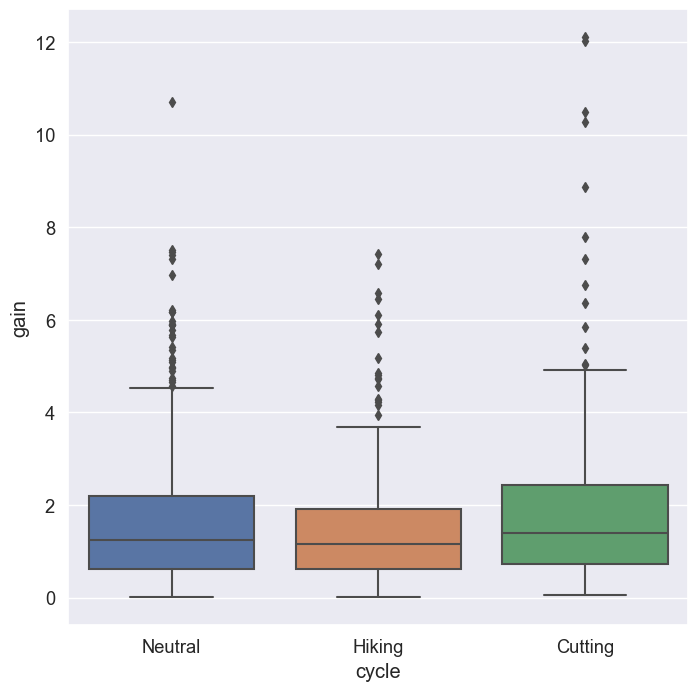

In [1236]:
sns.boxplot(data = df_w_t_lead[df_w_t_lead.gain > 0], x = 'cycle', y = 'gain')
plt.show()

Now the picture is clearer. Not only does Cutting have a higher median, all the high outliers belong to Cutting as well, with Hiking weekly returns never exceeding 7.5%.

Let's take a closer look at these outliers.

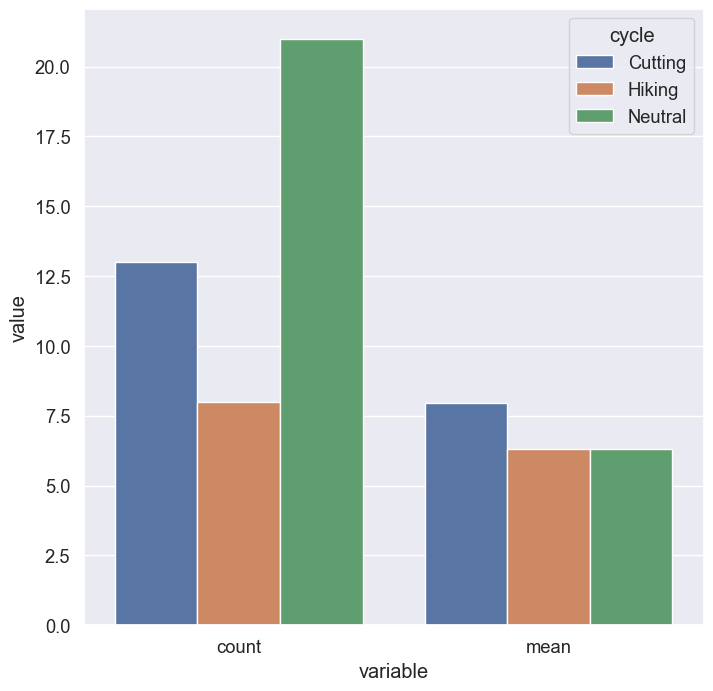

In [1237]:
sns.barplot(data = df_w_t_lead[df_w_t_lead.gain >= 5].pivot_table\
            (index = 'cycle', values = 'gain', aggfunc = ('count', 'mean'))\
            .reset_index().melt(id_vars = 'cycle'), x = 'variable', y = 'value', hue = 'cycle')
plt.show()

The outliers, too, are particularly weak in the Hiking category.

So to sum up, it is entirely possible that avoiding any kind of weekly long trade when the market is in a Hiking cycle is warranted. Without further research, Hiking seems like it should be avoided, particularly for call options, which are particularly sensitive to the presence of large outliers.

#### MONTHLY BASIS

In [1238]:
# Add a new DataFrame with a lagging value to show beginning of period indicator => end of period market return
# Comparison will now be <end of previous month> to <end of this month>
df_m_t_lead = df_m.join(df_ffrt.resample('M').last().cycle.shift(1))
# Test: we knew hiking began on 2022-03-17, so Hiking should show up in cycle 2022-04-30
df_m_t_lead['2022-03-31':'2022-05-31']

,close,FFR,close_1m,m_chg,gain,outlier,FFR_bin,FFR_bin_1m,cycle
DATE,,,,,,,,,
2022-03-31,4530.41,0.33,4373.94,3.58,3.58,False,"(0.04, 1.0]","(0.04, 1.0]",Neutral
2022-04-30,4131.93,0.33,4530.41,-8.80,0.00,False,"(0.04, 1.0]","(0.04, 1.0]",Hiking
2022-05-31,4132.15,0.83,4131.93,0.01,0.01,False,"(0.04, 1.0]","(0.04, 1.0]",Hiking


In [1239]:
round(df_m_t_lead.groupby(by = 'cycle').mean(), 4)

,close,FFR,close_1m,m_chg,gain,outlier
cycle,,,,,,
Cutting,806.3067,5.9138,803.2167,0.4291,2.1563,0.2111
Hiking,810.6562,6.8373,813.6421,0.6349,2.1350,0.2179
Neutral,1343.6412,3.4918,1331.2554,0.8870,2.0034,0.1830


This time the data is inconclusive. Neutral seems to be the best in terms of overall average, but it also has the lowest gain. Cutting and Hiking are too close together to draw any meaningful conclusions. There does not seem to be any trading need to avoid any of these categories.

### 3. What is the overall FFR's relationship with large, outsized moves in stocks?

#### DAILY BASIS

In [1240]:
# Reuse lagged DataFrame from question 1 above
df.head()

,close,FFR,close_1d,day_chg,gain,weekday,outlier,FFR_bin,FFR_bin_1d
DATE,,,,,,,,,
1976-01-02,90.9,5.28,NaN,NaN,NaN,5,False,"(5.0, 7.0]",NaN
1976-01-05,92.6,5.29,90.9,1.87,1.87,1,True,"(5.0, 7.0]","(5.0, 7.0]"
1976-01-06,93.5,5.05,92.6,0.97,0.97,2,False,"(5.0, 7.0]","(5.0, 7.0]"
1976-01-07,93.9,4.26,93.5,0.43,0.43,3,False,"(3.5, 5.0]","(5.0, 7.0]"
1976-01-08,94.6,4.84,93.9,0.75,0.75,4,False,"(3.5, 5.0]","(3.5, 5.0]"


In [1241]:
round(df.groupby(by = 'FFR_bin_1d').mean()[['outlier']], 4)

,outlier
FFR_bin_1d,
"(0.04, 0.5]",0.1227
"(0.5, 2.0]",0.1086
"(2.0, 3.5]",0.0766
"(3.5, 5.0]",0.0929
"(5.0, 7.0]",0.0959
"(7.0, 10.0]",0.0897
"(10.0, 22.36]",0.0907


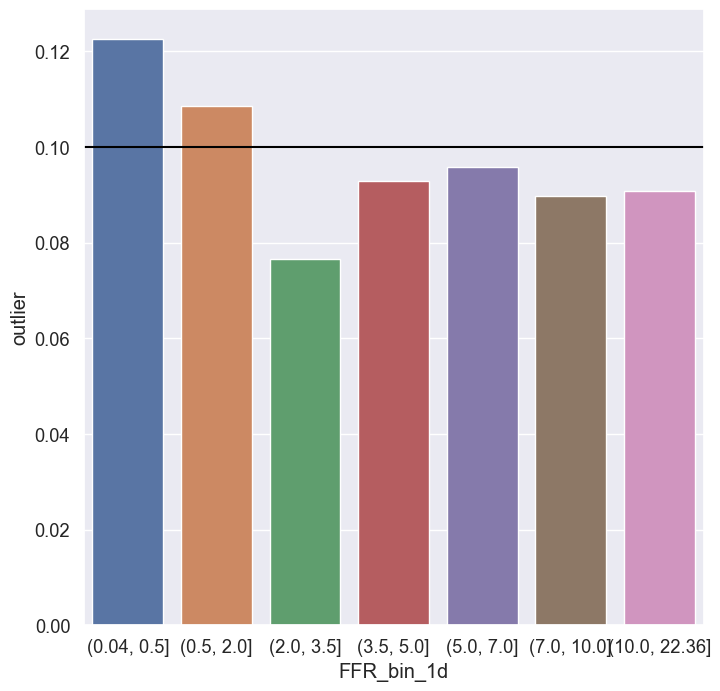

In [1242]:
# Plot findings
p = sns.barplot(data = df.groupby(by = 'FFR_bin_1d').mean()[['outlier']].reset_index(),\
           x = 'FFR_bin_1d', y = 'outlier')
p.axhline(0.1, color = 'black')
plt.show()

The percentage of outliers <strong>(here defined as belonging to the 90th percentile of overall historical returns or greater)</strong> is higher for the lowest rate bracket. Every rate bracket besides the first two has fewer than the expected 10% of gains in this range.

This might not be remarkable if we didn't have so many other patterns pointing to lower rates being predictors of stronger returns, but since we do, it's just another proof positive that lower rates are good for stocks.

#### WEEKLY BASIS

In [1243]:
# Reuse lagged DataFrame from question 1 above
df_w.head()

,close,FFR,weekday,close_1w,wk_chg,gain,outlier,FFR_bin,FFR_bin_1w
DATE,,,,,,,,,
1976-01-04,90.9,5.28,5,NaN,NaN,NaN,False,"(4.0, 5.5]",NaN
1976-01-11,94.9,4.73,5,90.9,4.40,4.40,True,"(4.0, 5.5]","(4.0, 5.5]"
1976-01-18,97.0,4.82,5,94.9,2.21,2.21,True,"(4.0, 5.5]","(4.0, 5.5]"
1976-01-25,99.2,4.72,5,97.0,2.27,2.27,True,"(4.0, 5.5]","(4.0, 5.5]"
1976-02-01,100.9,4.84,5,99.2,1.71,1.71,True,"(4.0, 5.5]","(4.0, 5.5]"


In [1244]:
round(df_w.groupby(by = 'FFR_bin_1w').mean()[['outlier']], 4)

,outlier
FFR_bin_1w,
"(0.04, 1.5]",0.2028
"(1.5, 4.0]",0.1608
"(4.0, 5.5]",0.2143
"(5.5, 8.0]",0.2130
"(8.0, 20.61]",0.2081


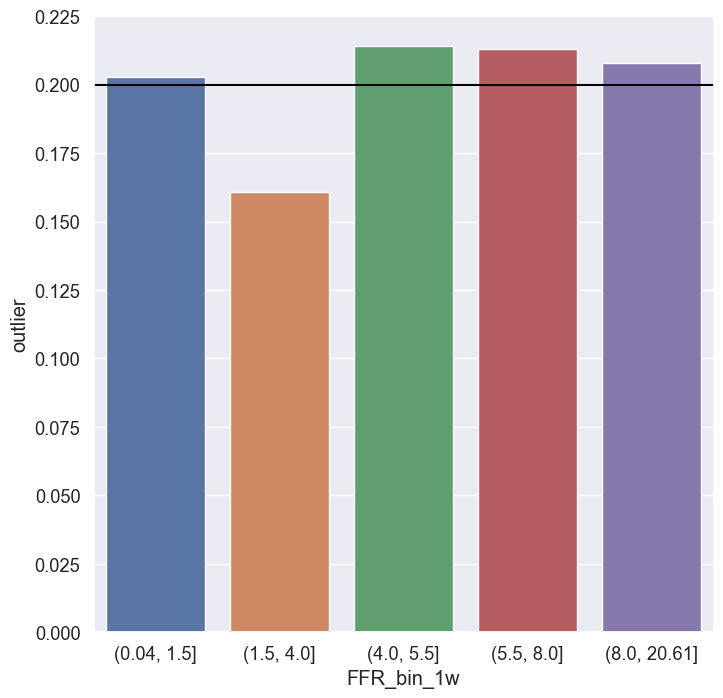

In [1245]:
p = sns.barplot(data = df_w.groupby(by = 'FFR_bin_1w').mean()[['outlier']].reset_index(),\
           x = 'FFR_bin_1w', y = 'outlier')
p.axhline(0.2, color = 'black')
plt.show()

The percentage of outliers <strong>(here defined as belonging to the 80th percentile of overall historical returns or greater)</strong> is similar for most brackets. The 150-400 bracket has a strikingly low percentage of outliers, just like it has a strikingly low average gain.

#### MONTHLY BASIS

In [1246]:
# Reuse lagged DataFrame from question 1 above
df_m.head()

,close,FFR,close_1m,m_chg,gain,outlier,FFR_bin,FFR_bin_1m
DATE,,,,,,,,
1976-01-31,100.9,4.84,NaN,NaN,NaN,False,"(4.5, 7.0]",NaN
1976-02-29,99.7,4.89,100.9,-1.19,0.00,False,"(4.5, 7.0]","(4.5, 7.0]"
1976-03-31,102.8,5.07,99.7,3.11,3.11,False,"(4.5, 7.0]","(4.5, 7.0]"
1976-04-30,101.6,5.10,102.8,-1.17,0.00,False,"(4.5, 7.0]","(4.5, 7.0]"
1976-05-31,100.2,5.67,101.6,-1.38,0.00,False,"(4.5, 7.0]","(4.5, 7.0]"


In [1247]:
round(df_m.groupby(by = 'FFR_bin_1m').mean()[['outlier']], 4)

,outlier
FFR_bin_1m,
"(0.04, 1.0]",0.2061
"(1.0, 4.5]",0.1095
"(4.5, 7.0]",0.2278
"(7.0, 22.0]",0.2353


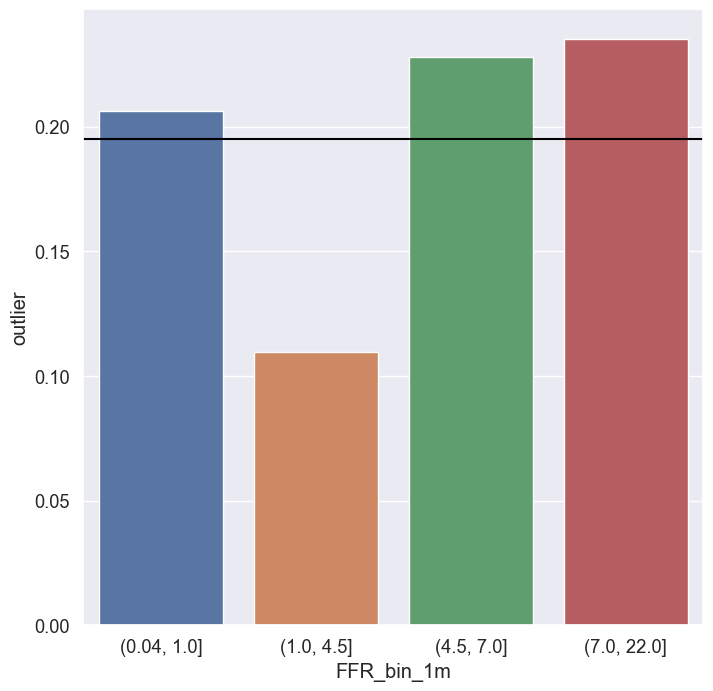

In [1248]:
p = sns.barplot(data = df_m.groupby(by = 'FFR_bin_1m').mean()[['outlier']].reset_index(),\
           x = 'FFR_bin_1m', y = 'outlier')
p.axhline(0.195, color = 'black')
plt.show()

In [1249]:
df_m[df_m.m_chg >= 4].shape[0] / df_m.shape[0]

0.19680851063829788

<strong>Outliers are here defined as returns of 4% or more, which are 19.7% of total market returns.</strong>

Yet again, the middle bracket of interest rates (100-450 bps in this case) has a paucity of outliers, a weak point that would be noticeable even if we had no other information. With the other evidence, it's an overpowering case that low and high rates lead to better stock market returns than moderate rates.

### 4. What is the FFR trajectory's relationship with large, outsized moves in stocks?

#### DAILY BASIS

In [1250]:
# Reuse lagged DataFrame from question 2 above
df_t_lead.head()

,close,FFR,close_1d,day_chg,gain,weekday,outlier,FFR_bin,FFR_bin_1d,cycle
DATE,,,,,,,,,,
1976-01-02,90.9,5.28,NaN,NaN,NaN,5,False,"(5.0, 7.0]",NaN,NaN
1976-01-05,92.6,5.29,90.9,1.87,1.87,1,True,"(5.0, 7.0]","(5.0, 7.0]",Neutral
1976-01-06,93.5,5.05,92.6,0.97,0.97,2,False,"(5.0, 7.0]","(5.0, 7.0]",Neutral
1976-01-07,93.9,4.26,93.5,0.43,0.43,3,False,"(3.5, 5.0]","(5.0, 7.0]",Neutral
1976-01-08,94.6,4.84,93.9,0.75,0.75,4,False,"(3.5, 5.0]","(3.5, 5.0]",Neutral


In [1251]:
round(df_t_lead.groupby(by = 'cycle').mean()[['outlier']], 4)

,outlier
cycle,
Cutting,0.1275
Hiking,0.0901
Neutral,0.0955


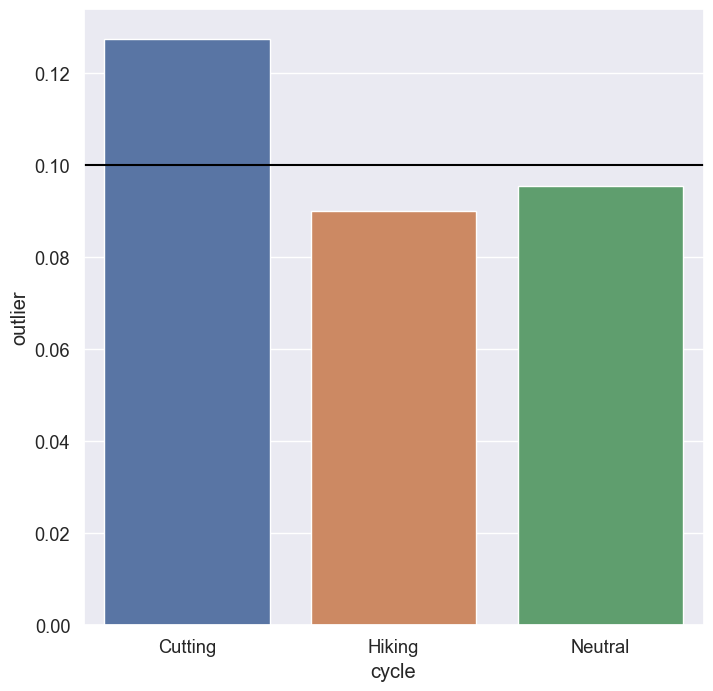

In [1252]:
p = sns.barplot(data = df_t_lead.groupby(by = 'cycle').mean()[['outlier']].reset_index(),\
           x = 'cycle', y = 'outlier')
p.axhline(0.1, color = 'black')
plt.show()

Cutting is over-represented when it comes to the number of outliers <strong>(here defined as belonging to the 90th percentile of overall historical returns or greater)</strong>, and Neutral ialso performs a bit poorly, but again Hiking is the worst. By now the story is familiar: increasing rates aren't good for returns.

#### WEEKLY BASIS

In [1253]:
# Reuse lagged DataFrame from question 2 above
df_w_t_lead.head()

,close,FFR,weekday,close_1w,wk_chg,gain,outlier,FFR_bin,FFR_bin_1w,cycle
DATE,,,,,,,,,,
1976-01-04,90.9,5.28,5,NaN,NaN,NaN,False,"(4.0, 5.5]",NaN,NaN
1976-01-11,94.9,4.73,5,90.9,4.40,4.40,True,"(4.0, 5.5]","(4.0, 5.5]",Neutral
1976-01-18,97.0,4.82,5,94.9,2.21,2.21,True,"(4.0, 5.5]","(4.0, 5.5]",Neutral
1976-01-25,99.2,4.72,5,97.0,2.27,2.27,True,"(4.0, 5.5]","(4.0, 5.5]",Neutral
1976-02-01,100.9,4.84,5,99.2,1.71,1.71,True,"(4.0, 5.5]","(4.0, 5.5]",Neutral


In [1254]:
round(df_w_t_lead.groupby(by = 'cycle').mean()[['outlier']], 4)

,outlier
cycle,
Cutting,0.2369
Hiking,0.1710
Neutral,0.1981


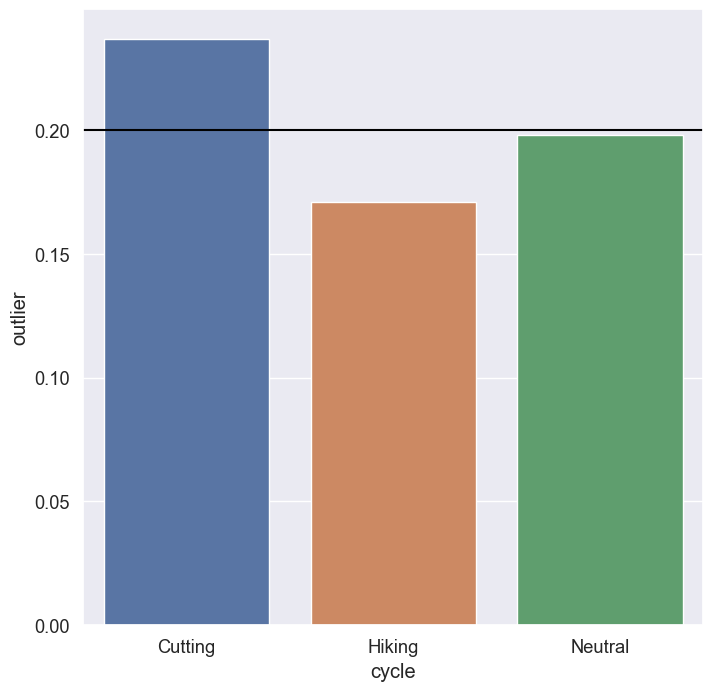

In [1255]:
p = sns.barplot(data = df_w_t_lead.groupby(by = 'cycle').mean()[['outlier']].reset_index(),\
           x = 'cycle', y = 'outlier')
p.axhline(0.2, color = 'black')
plt.show()

The percentage of outliers <strong>(here defined as belonging to the 80th percentile of overall historical returns or greater)</strong> is somewhat similar to the daily data. Neutral is right on the average, and Cutting outperforms by the same amount that Hiking underperforms by.

#### MONTHLY BASIS

In [1256]:
# Reuse lagged DataFrame from question 2 above
df_m_t_lead.head()

,close,FFR,close_1m,m_chg,gain,outlier,FFR_bin,FFR_bin_1m,cycle
DATE,,,,,,,,,
1976-01-31,100.9,4.84,NaN,NaN,NaN,False,"(4.5, 7.0]",NaN,NaN
1976-02-29,99.7,4.89,100.9,-1.19,0.00,False,"(4.5, 7.0]","(4.5, 7.0]",Neutral
1976-03-31,102.8,5.07,99.7,3.11,3.11,False,"(4.5, 7.0]","(4.5, 7.0]",Neutral
1976-04-30,101.6,5.10,102.8,-1.17,0.00,False,"(4.5, 7.0]","(4.5, 7.0]",Neutral
1976-05-31,100.2,5.67,101.6,-1.38,0.00,False,"(4.5, 7.0]","(4.5, 7.0]",Hiking


In [1257]:
round(df_m_t_lead.groupby(by = 'cycle').mean()[['outlier']], 4)

,outlier
cycle,
Cutting,0.2111
Hiking,0.2179
Neutral,0.1830


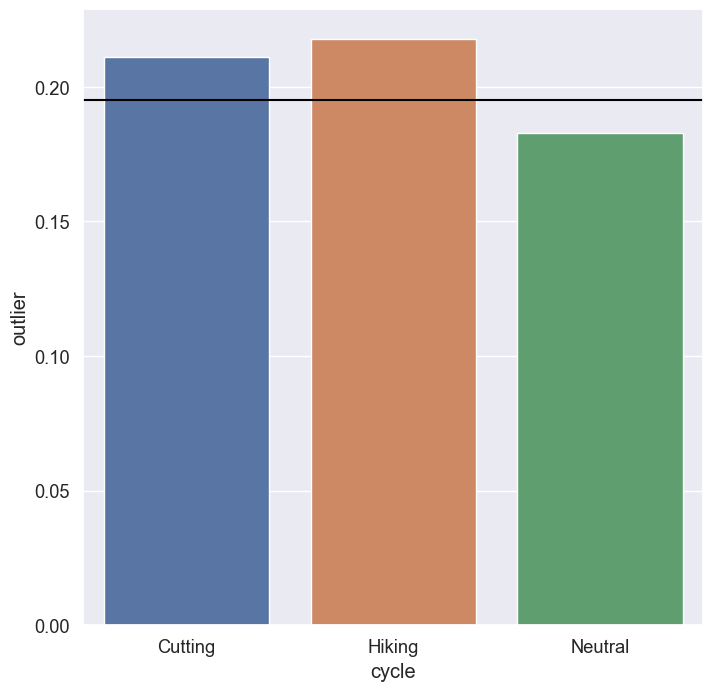

In [1258]:
p = sns.barplot(data = df_m_t_lead.groupby(by = 'cycle').mean()[['outlier']].reset_index(),\
           x = 'cycle', y = 'outlier')
p.axhline(0.195, color = 'black')
plt.show()

<strong>Outliers are here defined as returns of 4% or more, which are 19.7% of total market returns.</strong>

Here the story is different: there is no meaningful gap between Cutting and Hiking returns. It would seem that Hiking cycles significantly reduce the chance of an outsized gain in the S&P 500 on a daily and weekly basis, but on a monthly basis, the trajectory or cycle has little impact on the outlier distribution.

### Trading Recommendations

<ul>
    <li>Daily
        <ul>
            <li>Under 2%&mdash;Increase exposure</li>
            <li>2-5%&mdash;Reduce exposure or avoid</li>
            <li>Hiking cycles&mdash;Avoid</li>
        </ul>
    </li>
    <li>Weekly
        <ul>
            <li>Under 1.5%&mdash;Increase exposure</li>
            <li>1.5-4%&mdash;Reduce exposure or avoid</li>
            <li>Hiking cycles&mdash;Avoid</li>
        </ul>
    </li>
    <li>Monthly
        <ul>
            <li>1-4.5%&mdash;Reduce exposure or avoid</li>
        </ul>
    </li>
</ul>